## Timelapse notebook

In [31]:
from timelapse import *

In [33]:
sys.path.insert(1, '../source/python')
output_dir = '../output/'
os.makedirs(output_dir,exist_ok=True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 100)
plt.rcParams["figure.figsize"] = (12,6)

In [34]:
file_roma_standardized = '../data/temp_data/ro_standard.xlsx'
file_roma_IDA = '../data/roma_blind_prediction/ID segmentali con IDA Score.xlsx'
file_roma_blind = '../data/roma_blind_prediction/inviato a matteo_v3.xlsx'
file_roma_blind_correction = '../data/roma_blind_prediction/segmentali_per_silvia_SC_MF.xlsx'
file_valencia_standardized = '../data/temp_data/va_standard.xlsx'
file_uk_standardized = '../data/temp_data/uk_standard.xlsx'
file_bologna = '../data/input_data/9.baby TLM Mophokinetics Parameters.xlsx'

In [35]:
# definire i parametri utilizzati
selected_feature_list = ['tPNa_imp','t3_imp','t5_imp','t6_imp','t7_imp','t8_imp','t9_imp','cc3_imp', 's3_imp','blast_imp']
raw_feature_list = ['tPNa', 'tPNf', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 'tM', 'tSB', 'tB', 'tEB']
# parametri per dataset Genera aggiuntivi
grading_dict = {'AA':'AA','AB':'AB,BA','BA':'AB,BA','AC':'AC,CA,BB','CA':'AC,CA,BB','BB':'AC,CA,BB','CB':'CC,BC,CB','BC':'CC,BC,CB','CC':'CC,BC,CB','-':'-'}
grading_dict_num = {'AA':0,'AB,BA':1,'AC,CA,BB':2,'CC,BC,CB':3,'-':4}

## Starter datasets

In [36]:
# load and clean roma
# dataset roma contiene anche i dati aggiuntivi di IDA score
df_roma = pd.read_excel(file_roma_standardized)
df_roma['Sample ID'] = df_roma['patient_ID'].astype(str)+'_'+df_roma['embryo_ID'].astype(str)+'.'+df_roma['treatment_ID'].astype(str)
df_roma['class'] = df_roma['classification'].map({'eup':'eup','ane':'aneup','seg':'segm','ane_seg':'segm+aneup'})
df_roma = df_roma.replace('-',np.nan)
df_ida = pd.read_excel(file_roma_IDA)#,sheet_name='Cleavage features')
df_ida['ida score'] = df_ida['ida score'].replace('missing',None).astype(float)
df_ida.rename(columns={'operator\'s grading':'operators\' grading','ida score':'IDA Score'},inplace=True)
df_ida['grading_grouped'] = df_ida['operators\' grading'].map(grading_dict)
df_ida['grading_grouped_num'] = df_ida['grading_grouped'].map(grading_dict_num).fillna(4)
df_roma = pd.merge(df_roma,df_ida,on=['Sample ID'])

In [37]:
df_roma.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,classification,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,Sample ID,class,escope cose_well,center ID,Molecular Karyotype,note,operators' grading,date,IDA Score,grading_grouped,grading_grouped_num
0,GeneraLife,7740,2,1,eup,NaN,7.135,23.499,26.001,38.008,39.259,53.767,65.774,71.026,83.612,83.862,NaN,86.615,118.202,198.703,NaN,7740_1.2,eup,D2015.11.14_S1384_I141_1,roma,euploid,la data corretta e' 20/03/2013,CC,2013-03-20,2.030342,"CC,BC,CB",3
1,GeneraLife,7740,2,2,ane,NaN,19.392,37.511,42.762,43.012,61.024,61.274,96.468,96.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7740_2.2,aneup,D2015.11.14_S1384_I141_2,roma,+22,NaN,CC,2013-03-20,1.828950,"CC,BC,CB",3
2,GeneraLife,7740,2,5,seg,NaN,7.500,24.200,NaN,30.600,39.900,40.200,53.700,54.200,55.900,75.100,NaN,93.600,109.400,118.100,122.6,7740_5.2,segm,D2015.11.14_S1384_I141_5,roma,+16q,NaN,-,2013-03-20,1.828950,-,4


In [38]:
#load and clean unblind
df_unblind = pd.read_excel(file_roma_blind,sheet_name='unblinded')
df_unblind['IDA Score'] = df_unblind['IDA Score'].replace('-',None).astype(float)
df_unblind['grading_grouped'] = df_unblind['operators\' grading'].map(grading_dict)
df_unblind['grading_grouped_num'] = df_unblind['grading_grouped'].map(grading_dict_num).fillna(4)
df_unblind['class'] = df_unblind['eup, aneup, segm, segm+aneup'].map({0:'eup',1:'aneup',2:'segm',3:'segm+aneup'})
df_unblind = df_unblind.replace('-',np.nan)
df_unblind = df_unblind.rename(columns={'t9+':'t9'})
df_unblind_correction = pd.read_excel(file_roma_blind_correction)
for i,j in df_unblind_correction.iterrows():
    embryoID = j['ID_Emb']
    corrected_class = j['CheckClass eup ane seg aneseg']
    df_unblind.loc[df_unblind['ID_Emb']==embryoID,'class'] = corrected_class
df_unblind = df_unblind[df_unblind['class']!='?'].reset_index()
df_unblind['centre_ID'] = 'roma_unblind'
df_unblind['patient_ID'] = df_unblind['ID_Emb'].str.split('_').apply(lambda x: x[0])
df_unblind['treatment_ID'] = df_unblind['ID_Ciclo']
df_unblind['embryo_ID'] = df_unblind['ID_Emb']

#load and clean blind
df_blind = pd.read_excel(file_roma_blind,sheet_name='blinded')
df_blind['IDA Score'] = df_blind['IDA Score'].replace('-',None).astype(float)
df_blind['grading_grouped'] = df_blind['operators\' grading'].map(grading_dict)
df_blind['grading_grouped_num'] = df_blind['grading_grouped'].map(grading_dict_num).fillna(4)
df_blind = df_blind.replace('-',np.nan)
df_blind = df_blind.rename(columns={'t9+':'t9'})
df_blind['centre_ID'] = 'roma_blind'
df_blind['patient_ID'] = df_blind['ID_Emb'].str.split('_').apply(lambda x: x[0])
df_blind['treatment_ID'] = df_blind['ID_Ciclo']
df_blind['embryo_ID'] = df_blind['ID_Emb']

In [39]:
df_unblind.head(3)

,index,ID_Ciclo,ID_Emb,IDCoppia,ID_Ciclo.1,Ciclo,IDCiclo_Link,Well,(inst/slide),slide_Well,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tM,tSB,tB,tEB,Diagnosi,segmental NY,"eup, aneup, segm, segm+aneup",operators' grading,IDA Score,Maternal Age,check,Duplicato,grading_grouped,grading_grouped_num,class,centre_ID,patient_ID,treatment_ID,embryo_ID
0,0,11038_4,11038_1.4,11038,11038_4,4,NaN,1,D2021.05.26_S00066_I4360_P,D2021.05.26_S00066_I4360_P_1,7.566,20.979,23.118,34.484,34.996,48.514,NaN,NaN,60.787,NaN,NaN,93.681,99.690,109.572,+21,0,1,AA,8.9,37,NaN,NaN,AA,0,aneup,roma_unblind,11038,11038_4,11038_1.4
1,1,11038_4,11038_4.4,11038,11038_4,4,NaN,4,D2021.05.26_S00066_I4360_P,D2021.05.26_S00066_I4360_P_4,10.200,22.793,25.159,NaN,42.332,63.859,NaN,NaN,65.563,NaN,NaN,125.015,132.088,132.271,euploide,0,0,AA,7.5,37,NaN,NaN,AA,0,eup,roma_unblind,11038,11038_4,11038_4.4
2,2,11038_4,11038_5.4,11038,11038_4,4,NaN,5,D2021.05.26_S00066_I4360_P,D2021.05.26_S00066_I4360_P_5,9.215,22.467,24.822,37.217,37.387,54.655,NaN,NaN,60.280,NaN,NaN,103.108,114.068,116.415,+6,0,1,AB,6.3,37,NaN,NaN,"AB,BA",1,aneup,roma_unblind,11038,11038_4,11038_5.4


In [40]:
df_blind.head(3)

,ID_Ciclo,ID_Emb,IDCoppia,ID_Ciclo.1,Ciclo,IDCiclo_Link,Well,(inst/slide),slide_Well,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tM,tSB,tB,tEB,Diagnosi,segmental NY,"eup, aneup, segm, segm+aneup",operators' grading,IDA Score,Maternal Age,duplicato,grading_grouped,grading_grouped_num,centre_ID,patient_ID,treatment_ID,embryo_ID
0,23557_1,23557_1.1,23557,23557_1,1,NaN,1,D2021.04.30_S00021_I4360_P,D2021.04.30_S00021_I4360_P_1,8.495,25.093,27.719,37.661,38.599,53.147,NaN,NaN,55.595,NaN,NaN,101.806,108.832,117.038,NaN,NaN,NaN,AB,6.4,37,NaN,"AB,BA",1,roma_blind,23557,23557_1,23557_1.1
1,23557_1,23557_2.1,23557,23557_1,1,NaN,2,D2021.04.30_S00021_I4360_P,D2021.04.30_S00021_I4360_P_2,6.859,21.421,24.344,34.661,35.036,46.503,NaN,NaN,48.951,NaN,NaN,93.126,99.298,107.160,NaN,NaN,NaN,AA,9.3,37,NaN,AA,0,roma_blind,23557,23557_1,23557_2.1
2,23566_1,23566_11.1,23566,23566_1,1,NaN,11,D2021.07.30_S00178_I4360_P,D2021.07.30_S00178_I4360_P_11,8.219,25.542,27.917,38.946,39.116,39.285,NaN,NaN,67.403,NaN,NaN,100.333,122.272,123.770,NaN,NaN,NaN,BB,9.3,36,NaN,"AC,CA,BB",2,roma_blind,23566,23566_1,23566_11.1


In [41]:
#load and clean valencia
df_valencia = pd.read_excel(file_valencia_standardized)
df_valencia['class'] = df_valencia['classification'].map({'eup':'eup','ane':'aneup','seg':'segm','ane_seg':'segm+aneup'})
df_valencia = df_valencia.replace('-',np.nan)

In [42]:
df_valencia.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,tHB,classification,class
0,IVIRMA,24600086,1162530,11625302,4.691756,8.943418,22.656076,25.157386,35.914248,37.164727,44.922296,45.672729,51.069554,56.321618,72.520932,NaN,92.524525,110.175480,120.255914,NaN,NaN,ane,aneup
1,IVIRMA,24600086,1162530,11625303,3.192638,7.194379,21.303973,23.658509,24.659033,32.663929,35.165776,42.670238,44.423722,56.074834,59.326616,NaN,81.525903,90.028877,98.924990,NaN,NaN,ane,aneup
2,IVIRMA,24600086,1162530,11625304,2.694258,6.947665,25.160933,27.663141,29.414341,38.420329,39.419396,53.073514,54.824809,58.827855,68.721377,NaN,87.279586,96.120639,102.426109,NaN,NaN,ane,aneup


In [43]:
#load and clean UK
df_uk = pd.read_excel(file_uk_standardized)
df_uk['class'] = df_uk['classification'].map({'eup':'eup','ane':'aneup','seg':'segm','ane_seg':'segm+aneup'})
df_uk = df_uk.replace('-',np.nan)

In [44]:
df_uk.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,classification,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,tHB,class
0,Care-Fertility,101334,57136,0,seg,3.117706,6.621338,28.130989,31.633202,42.140834,42.638908,46.974684,54.812421,55.314975,56.646939,58.481107,90.996477,96.666114,102.001149,NaN,NaN,NaN,segm
1,Care-Fertility,110535,55397,1,ane_seg,4.693487,9.364579,20.206004,23.601624,34.441532,38.110821,46.952163,51.622867,52.623023,64.140723,66.850828,NaN,93.263283,97.932211,106.103754,113.774470,NaN,segm+aneup
2,Care-Fertility,110535,55397,2,ane_seg,3.531621,8.035138,25.608747,27.608386,39.452262,40.117197,52.125833,54.293604,54.293604,56.794494,71.221563,NaN,NaN,91.934280,99.938232,113.112612,NaN,segm+aneup


In [45]:
#load bologna
df_bologna = pd.read_excel(file_bologna)
df_bologna['centre_ID']='bologna'
df_bologna['treatment_ID'] = df_bologna['Sample ID'].str.split('_').apply(lambda x: x[0])
df_bologna['patient_ID'] = df_bologna['Sample ID'].str.split('_').apply(lambda x: x[0])
df_bologna['class'] = 'eup'
df_bologna.loc[df_bologna['Molecular Karyotype'].apply(lambda x: 'ANEUPLOIDE' in x),'class']='aneup'
df_bologna.loc[df_bologna['Molecular Karyotype'].apply(lambda x: 'aneup' in x),'class']='aneup'
df_bologna.loc[df_bologna['Molecular Karyotype'].apply(lambda x: 'SEGMENTAL' in x),'class']='segm'
df_bologna.loc[df_bologna['Molecular Karyotype'].apply(lambda x: ',' in x),'class']='segm+aneup'
df_bologna.loc[df_bologna['Molecular Karyotype'].apply(lambda x: ('+' in x)&('-' in x)),'class']='segm+aneup'

df_bologna[['Molecular Karyotype','class']].drop_duplicates()

,Molecular Karyotype,class
0,EUPLOIDE,eup
3,SEGMENTALE +10q,segm
4,ANEUPLOIDE +19,aneup
8,"SEGMENTALE +15, -Xq",segm+aneup
11,ANEUPLOIDE -8,aneup
12,SEGMENTALE -14q +19,segm+aneup
13,ANEUPLOIDE +22,aneup
18,SEGMENTAL +9q,segm
22,SEGMENTAL -17q,segm
24,SEGMENTAL +18p,segm


In [46]:
df_bologna.head(3)

,Sample ID,center ID,Control\nGroup,Case\nGroup,Molecular Karyotype,tBP2,tPNA,tPNF,t2,t3,t4,t5,t6,t7,t8,tTM,tSC,tM,tSB,tB,tE,tHN,tHD,Psyn\nt2-PNf,s2\nt4-t3,s3\nt8-t5,ECC1\nt2-tPB2,cc2a\nt3-t2,cc2b\nt4-t2,cc3a\nt5-t4,cc3b\nt6-t4,cc3c\nt7-t4,cc3d\nt8-t4,ECC2\nt4-t2,ECC3\nt8-t4,Blastocyst Contraction,centre_ID,treatment_ID,patient_ID,class
0,15262_1,TEC15262,1.0,NaN,EUPLOIDE,2.511931,9.013879,21.408845,24.412063,33.916994,34.167043,44.423010,44.673118,45.173216,47.180114,NO TM,72.823849,89.708509,90.708750,97.960654,NV,NV,NaN,3.003218,0.250049,2.757105,21.900132,9.504931,9.754980,10.255967,10.506076,11.006174,13.013072,9.754980,13.013072,NaN,bologna,15262,15262,eup
1,15262_2,TEC15262,2.0,NaN,EUPLOIDE,1.764232,8.016008,20.019529,23.412186,32.669190,34.669701,42.675001,45.675733,45.675733,46.430197,NO TM,68.335518,72.575163,74.827012,87.080911,NV,NV,NaN,3.392657,2.000511,3.755196,21.647954,9.257004,11.257515,8.005300,11.006032,11.006032,11.760496,11.257515,11.760496,NaN,bologna,15262,15262,eup
2,15262_4,TEC15262,4.0,NaN,EUPLOIDE,2.269279,8.270863,21.166097,22.666747,33.924387,34.174447,45.930690,46.435113,46.435113,47.187402,NO TM,59.939055,73.840782,79.583569,89.716035,NV,NV,NaN,1.500650,0.250061,1.256711,20.397467,11.257640,11.507701,11.756243,12.260666,12.260666,13.012954,11.507701,13.012954,NaN,bologna,15262,15262,eup


In [47]:
# contiene anche bologna fare attenzione
df_all = pd.concat([df_roma, df_valencia, df_uk, df_unblind,df_bologna])

display(df_all.shape) # dimensione dataset merged
display(df_all.centre_ID.value_counts()) # dimensioni centro specifico
display(df_all['class'].value_counts()) # conte delle classi su dataset merged
display(pd.crosstab(df_all.centre_ID, df_all['class']))

(7631, 71)

IVIRMA            5546
Care-Fertility    1083
roma_unblind       549
GeneraLife         398
bologna             55
Name: centre_ID, dtype: int64

eup           3283
aneup         3148
segm           710
segm+aneup     490
Name: class, dtype: int64

class,aneup,eup,segm,segm+aneup
centre_ID,,,,
Care-Fertility,195,325,329,234
GeneraLife,150,138,46,64
IVIRMA,2473,2577,322,174
bologna,5,37,10,3
roma_unblind,325,206,3,15


In [48]:
df_all[['centre_ID','patient_ID','treatment_ID']].drop_duplicates().shape

(2382, 3)

In [49]:
display(df_all['class'].value_counts(normalize=True))
display(pd.crosstab(df_all.centre_ID,df_all['class'],normalize='index'))

eup           0.430219
aneup         0.412528
segm          0.093042
segm+aneup    0.064212
Name: class, dtype: float64

class,aneup,eup,segm,segm+aneup
centre_ID,,,,
Care-Fertility,0.180055,0.300092,0.303786,0.216066
GeneraLife,0.376884,0.346734,0.115578,0.160804
IVIRMA,0.445907,0.464659,0.058060,0.031374
bologna,0.090909,0.672727,0.181818,0.054545
roma_unblind,0.591985,0.375228,0.005464,0.027322


#### Missing timings

In [50]:
df_all[[t + '_missing' for t in raw_feature_list]] = df_all[raw_feature_list].isna()
df_all['num_missing'] = df_all[[t + '_missing' for t in raw_feature_list]].sum(axis=1)
df_all = df_all.reset_index(drop=True)

In [51]:
df_all.head(5)
#df_all['num_missing'].value_counts()

,centre_ID,patient_ID,treatment_ID,embryo_ID,classification,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,Sample ID,class,escope cose_well,center ID,Molecular Karyotype,note,operators' grading,date,IDA Score,grading_grouped,grading_grouped_num,tHB,index,ID_Ciclo,ID_Emb,IDCoppia,ID_Ciclo.1,Ciclo,IDCiclo_Link,Well,(inst/slide),slide_Well,Diagnosi,segmental NY,"eup, aneup, segm, segm+aneup",Maternal Age,check,Duplicato,Control\nGroup,Case\nGroup,tBP2,tPNA,tPNF,tTM,tE,tHN,tHD,Psyn\nt2-PNf,s2\nt4-t3,s3\nt8-t5,ECC1\nt2-tPB2,cc2a\nt3-t2,cc2b\nt4-t2,cc3a\nt5-t4,cc3b\nt6-t4,cc3c\nt7-t4,cc3d\nt8-t4,ECC2\nt4-t2,ECC3\nt8-t4,Blastocyst Contraction,tPNa_missing,tPNf_missing,t2_missing,t3_missing,t4_missing,t5_missing,t6_missing,t7_missing,t8_missing,t9_missing,tM_missing,tSB_missing,tB_missing,tEB_missing,num_missing
0,GeneraLife,7740,2,1,eup,NaN,7.135,23.499,26.001,38.008,39.259,53.767,65.774,71.026,83.612,83.862,NaN,86.615,118.202,198.703,NaN,7740_1.2,eup,D2015.11.14_S1384_I141_1,roma,euploid,la data corretta e' 20/03/2013,CC,2013-03-20,2.030342,"CC,BC,CB",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,True,1
1,GeneraLife,7740,2,2,ane,NaN,19.392,37.511,42.762,43.012,61.024,61.274,96.468,96.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7740_2.2,aneup,D2015.11.14_S1384_I141_2,roma,+22,NaN,CC,2013-03-20,1.828950,"CC,BC,CB",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,True,True,True,True,True,True,6
2,GeneraLife,7740,2,5,seg,NaN,7.500,24.200,NaN,30.600,39.900,40.200,53.700,54.200,55.900,75.100,NaN,93.600,109.400,118.100,122.600,7740_5.2,segm,D2015.11.14_S1384_I141_5,roma,+16q,NaN,-,2013-03-20,1.828950,-,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1
3,GeneraLife,7740,2,6,ane_seg,NaN,8.200,25.000,28.400,41.700,NaN,54.400,54.700,54.900,70.200,70.700,NaN,83.600,102.600,111.100,122.600,7740_6.2,segm+aneup,D2015.11.14_S1384_I141_6,roma,+4q +7 -18 +22,NaN,-,2013-03-20,1.828950,-,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1
4,GeneraLife,9363,12,2,eup,NaN,9.793,23.787,27.294,37.307,37.805,48.643,50.394,51.394,54.895,92.859,NaN,99.195,105.955,117.338,121.743,9363_2.12,eup,D2019.02.22_S02216_I0141_D_2,roma,EUPLOIDE,NaN,BC,2019-02-22,5.794730,"CC,BC,CB",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0


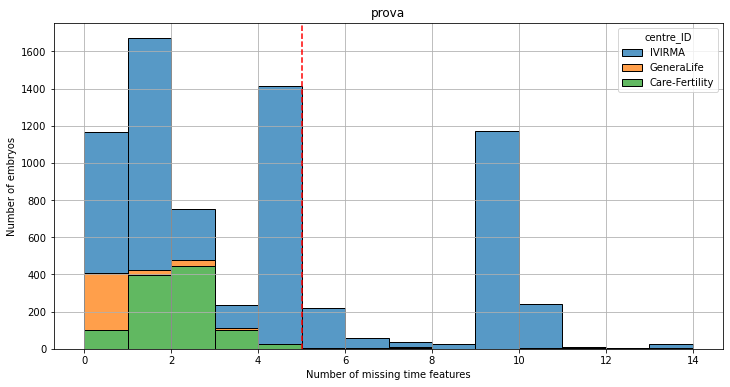

In [52]:
sns.histplot(data=df_all,x='num_missing',hue='centre_ID',stat='count',common_norm=False,multiple='stack',hue_order=['IVIRMA','GeneraLife','Care-Fertility'],bins=range(15),shrink=1)
plt.axvline(5,c='r',ls='--')
plt.xlabel('Number of missing time features')
plt.grid()
plt.ylabel('Number of embryos')
plt.title('prova')
plt.show()

#plt.savefig(os.path.join(output_dir,'Missing_stat_num.jpeg'))

In [53]:
# raw_feature_list = ['tPNa', 'tPNf', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 'tM', 'tSB', 'tB', 'tEB']
df_missing = df_all.groupby('centre_ID')[[t + '_missing' for t in raw_feature_list]].mean().reset_index()
df_missing

,centre_ID,tPNa_missing,tPNf_missing,t2_missing,t3_missing,t4_missing,t5_missing,t6_missing,t7_missing,t8_missing,t9_missing,tM_missing,tSB_missing,tB_missing,tEB_missing
0,Care-Fertility,0.550323,0.027701,0.000000,0.000923,0.000923,0.003693,0.006464,0.012004,0.025854,0.137581,0.024007,0.019391,0.046168,0.786704
1,GeneraLife,0.012563,0.012563,0.017588,0.052764,0.035176,0.032663,0.060302,0.050251,0.047739,0.042714,0.035176,0.047739,0.113065,0.120603
2,IVIRMA,0.559863,0.266859,0.004508,0.005409,0.006131,0.011179,0.269564,0.273170,0.281284,0.614677,0.575730,0.313559,0.112333,0.816985
3,bologna,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
4,roma_unblind,0.009107,0.012750,0.005464,0.014572,0.009107,0.007286,0.568306,0.568306,0.009107,0.573770,0.577413,0.025501,0.140255,0.142077


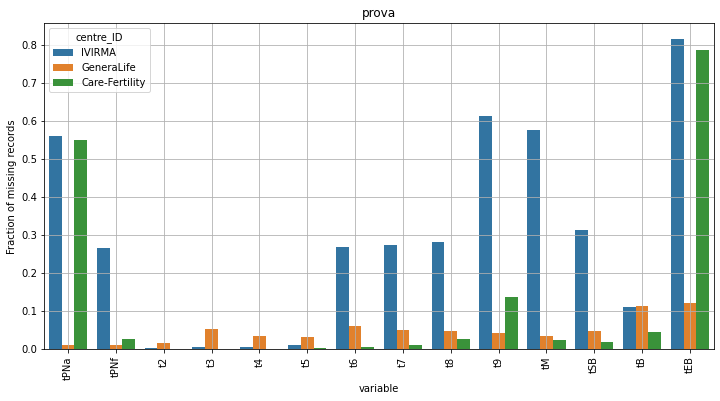

In [54]:
df_missing_melt = df_missing.melt(id_vars='centre_ID')

sns.barplot(data=df_missing_melt,y='value',x='variable',hue='centre_ID',hue_order=['IVIRMA','GeneraLife','Care-Fertility'])
plt.xticks(range(len(raw_feature_list)),raw_feature_list,rotation=90)
#plt.grid()
plt.ylabel('Fraction of missing records')
plt.grid()
plt.title('prova')
plt.show()
#plt.savefig(os.path.join(output_dir,'Missing_stat.jpeg'))

#### Boxplots

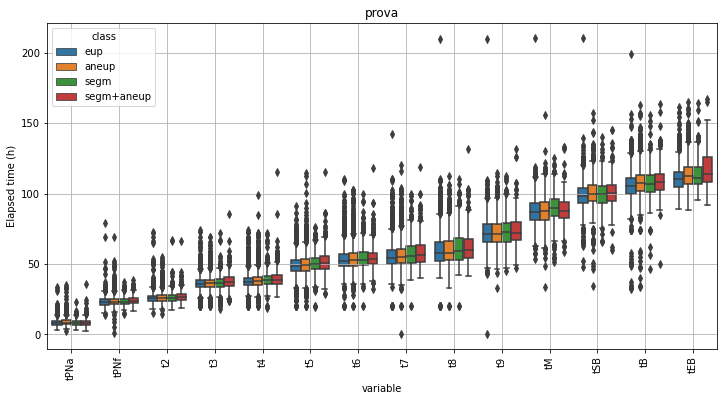

In [55]:
df_all_melt = df_all[['class']+raw_feature_list].melt(id_vars='class')

sns.boxplot(data=df_all_melt,y='value',x='variable',hue='class',hue_order=['eup','aneup','segm','segm+aneup'])
plt.xticks(range(len(raw_feature_list)),raw_feature_list,rotation=90)
plt.grid()
plt.ylabel('Elapsed time (h)')
plt.title('Multi-centers')
plt.title('prova')
plt.show()
#plt.savefig(os.path.join(output_dir,'boxplot_class.jpeg'))

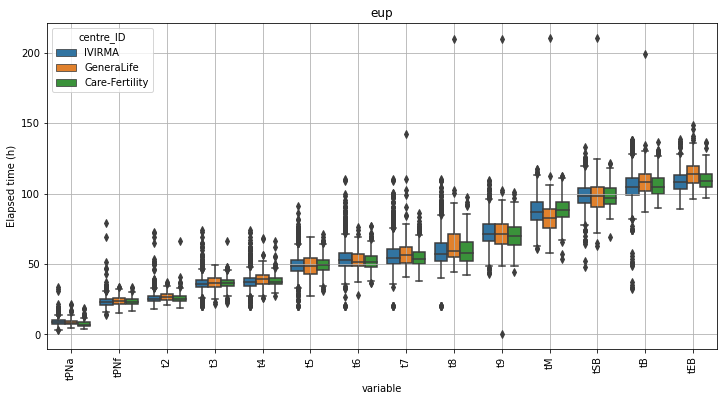

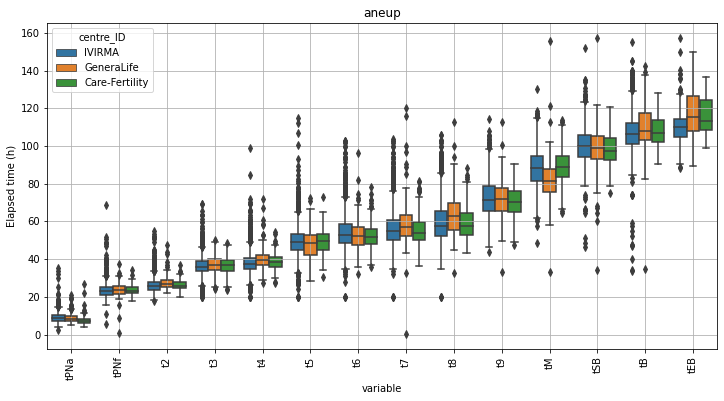

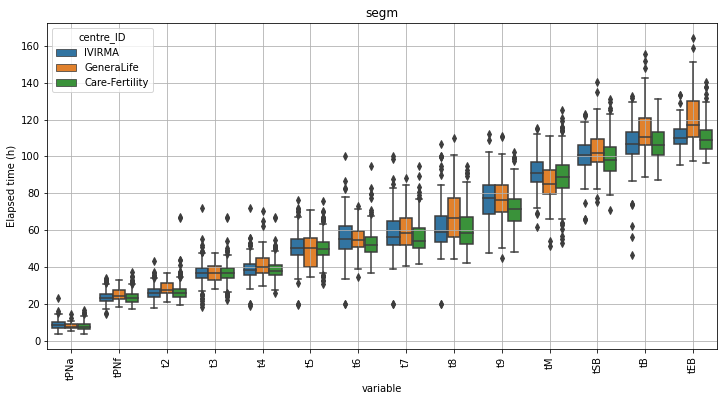

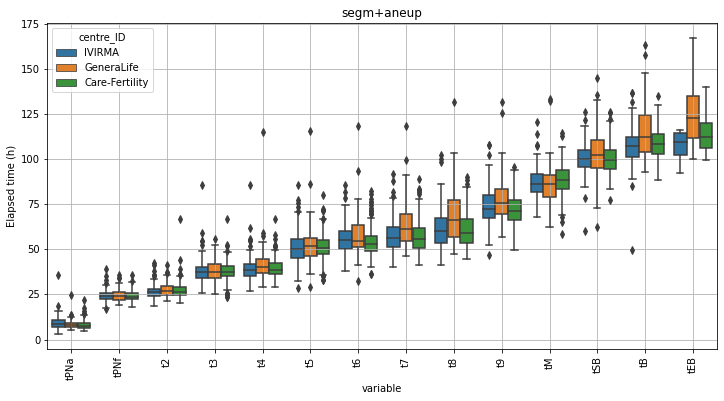

In [56]:
for myclass in df_all['class'].unique():
    df_all_melt = df_all.loc[df_all['class']==myclass,['centre_ID']+raw_feature_list].melt(id_vars='centre_ID')
    #print(myclass)
    plt.figure()
    sns.boxplot(data=df_all_melt,y='value',x='variable',hue='centre_ID',hue_order=['IVIRMA','GeneraLife','Care-Fertility'])
    plt.xticks(range(len(raw_feature_list)),raw_feature_list,rotation=90)
    plt.grid()
    plt.ylabel('Elapsed time (h)')
    plt.title(str(myclass))
    plt.show()
    #plt.savefig(os.path.join(output_dir,myclass+'.jpeg'))

#### Statistical tests

##### Kolmogorov Smirnov 2 samples

In [133]:
raw_feature_list

['tPNa',
 'tPNf',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 'tM',
 'tSB',
 'tB',
 'tEB']

In [ ]:
selected_feature_list

In [134]:
dataset_dict

{'GeneraLife':       centre_ID  patient_ID  treatment_ID  embryo_ID classification  tPB2    tPNa    tPNf      t2  \
 0    GeneraLife        7740             2          1            eup   NaN   7.135  23.499  26.001   
 1    GeneraLife        7740             2          2            ane   NaN  19.392  37.511  42.762   
 2    GeneraLife        7740             2          5            seg   NaN   7.500  24.200     NaN   
 3    GeneraLife        7740             2          6        ane_seg   NaN   8.200  25.000  28.400   
 4    GeneraLife        9363            12          2            eup   NaN   9.793  23.787  27.294   
 ..          ...         ...           ...        ...            ...   ...     ...     ...     ...   
 393  GeneraLife       23984             2          2            eup   NaN  11.400  22.600  25.200   
 394  GeneraLife       24405             2          1            ane   NaN   5.800  20.300  23.600   
 395  GeneraLife       24405             2          2            ane

In [135]:
df_ks2 = pd.DataFrame()
dataset_dict = {'GeneraLife':df_roma_processed,'Care-Fertility':df_uk_processed,'IVIRMA':df_valencia_processed,'allcenters':df_all_processed}

for center in dataset_dict.keys():
    dataset = dataset_dict[center]
    for t in tl_all.imputed_times:
    #for t in raw_feature_list + ['cc3_imp','cc2_imp','s2_imp','s3_imp','blast1_imp']:
        for c1 in ['eup','segm','aneup']:
            for c2 in ['eup','segm','aneup']:
                if c1 > c2:
                    list1 = dataset.loc[dataset['class']==c1, t].dropna()
                    list2 = dataset.loc[dataset['class']==c2, t].dropna()
                    effect = np.mean(list1) -np.mean(list2)

                    statistic, pvalue_ks = stats.ks_2samp(list1, list2)
                    statistic, pvalue_tind = stats.ttest_ind(list1,list2)
                    # statistic è un valore della statistica poco interpretabile 
                    # per tale motivo utilizziamo l'effetto medio dei tempi
                    df_ks2 = df_ks2.append({'center':center,
                                            'c1':c1,'c2':c2,
                                            'time':t,
                                            'effect':effect,
                                            'pvalue_ks':pvalue_ks,
                                            'pvalue_tind':pvalue_tind},
                                            ignore_index=True)

df_ks2['-log10p_ks'] = -np.log10(df_ks2['pvalue_ks'])
df_ks2['-log10p_tind'] = -np.log10(df_ks2['pvalue_tind'])
# non considerare il p_ttest che riguarda il test T indipendente a due campioni
# i nostri dati non sono parametrici

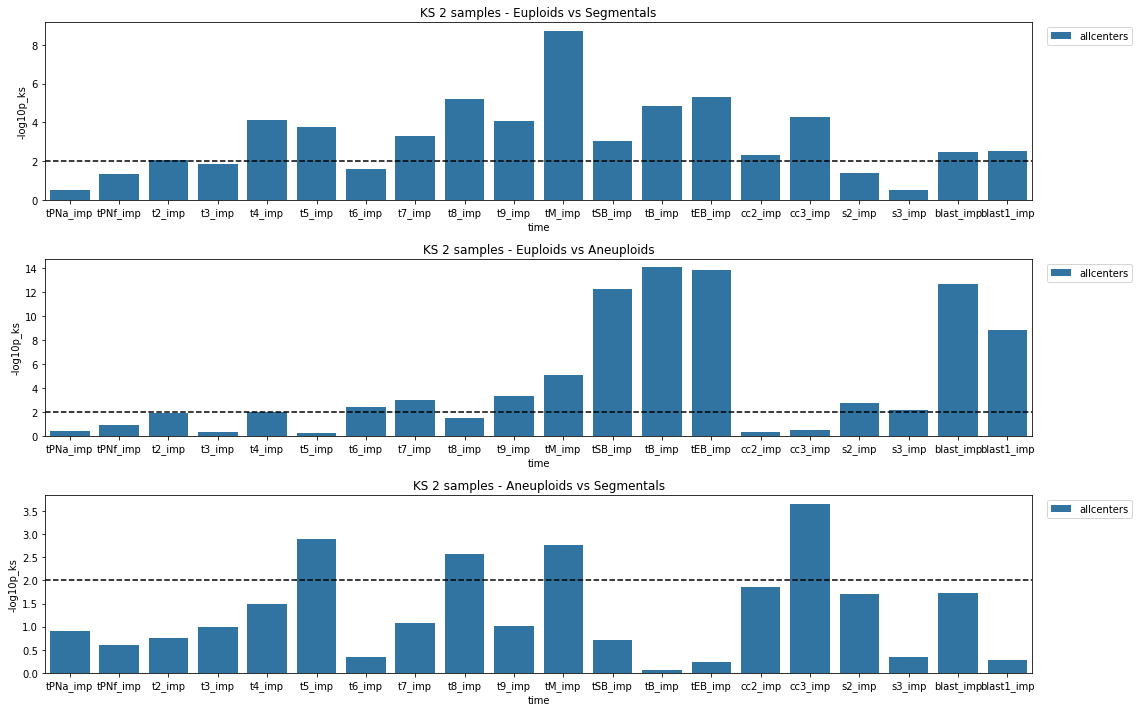

In [136]:
fig,ax = plt.subplots(3,1,figsize=(16,10))
ax[0].set_title('KS 2 samples - Euploids vs Segmentals')
sns.barplot(ax=ax[0],data=df_ks2[(df_ks2.c1=='segm')&(df_ks2.c2=='eup')],x='time',y='-log10p_ks',hue='center',hue_order=['allcenters'])
ax[1].set_title('KS 2 samples - Euploids vs Aneuploids')
sns.barplot(ax=ax[1],data=df_ks2[(df_ks2.c1=='eup')&(df_ks2.c2=='aneup')],x='time',y='-log10p_ks',hue='center',hue_order=['allcenters'])
ax[2].set_title('KS 2 samples - Aneuploids vs Segmentals')
sns.barplot(ax=ax[2],data=df_ks2[(df_ks2.c1=='segm')&(df_ks2.c2=='aneup')],x='time',y='-log10p_ks',hue='center',hue_order=['allcenters'])


ax[0].axhline(2,c='k',ls='--')
ax[1].axhline(2,c='k',ls='--')
ax[2].axhline(2,c='k',ls='--')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir,'significancy_ks.jpeg'))

In [137]:
df_ks2[(df_ks2.c1=='segm')&(df_ks2.c2=='eup')].head(30)

,c1,c2,center,effect,pvalue_ks,pvalue_tind,time,-log10p_ks,-log10p_tind
1,segm,eup,GeneraLife,-0.763035,0.162342,0.071968,tPNa_imp,0.789570,1.142858
4,segm,eup,GeneraLife,0.822960,0.383841,0.144499,tPNf_imp,0.415849,0.840136
7,segm,eup,GeneraLife,1.137901,0.195895,0.042428,t2_imp,0.707977,1.372348
10,segm,eup,GeneraLife,0.391067,0.579836,0.658659,t3_imp,0.236695,0.181339
13,segm,eup,GeneraLife,2.363489,0.234566,0.049828,t4_imp,0.629735,1.302528
16,segm,eup,GeneraLife,1.073016,0.510360,0.454728,t5_imp,0.292124,0.342248
19,segm,eup,GeneraLife,2.170343,0.070959,0.109175,t6_imp,1.148990,0.961878
22,segm,eup,GeneraLife,1.285995,0.234566,0.559833,t7_imp,0.629735,0.251942
25,segm,eup,GeneraLife,3.687162,0.012428,0.224864,t8_imp,1.905582,0.648080
28,segm,eup,GeneraLife,2.279329,0.133512,0.436895,t9_imp,0.874480,0.359623


In [138]:
df_ks2

,c1,c2,center,effect,pvalue_ks,pvalue_tind,time,-log10p_ks,-log10p_tind
0,eup,aneup,GeneraLife,0.138450,5.385976e-01,0.677197,tPNa_imp,0.268736,0.169285
1,segm,eup,GeneraLife,-0.763035,1.623418e-01,0.071968,tPNa_imp,0.789570,1.142858
2,segm,aneup,GeneraLife,-0.624584,5.076453e-01,0.176905,tPNa_imp,0.294440,0.752259
3,eup,aneup,GeneraLife,0.099647,7.983395e-01,0.813884,tPNf_imp,0.097812,0.089437
4,segm,eup,GeneraLife,0.822960,3.838407e-01,0.144499,tPNf_imp,0.415849,0.840136
...,...,...,...,...,...,...,...,...,...
235,segm,eup,allcenters,1.003611,3.223145e-03,0.008355,blast_imp,2.491720,2.078044
236,segm,aneup,allcenters,-0.783277,1.867799e-02,0.041781,blast_imp,1.728670,1.379022
237,eup,aneup,allcenters,-0.357011,1.355219e-09,0.001962,blast1_imp,8.867990,2.707308
238,segm,eup,allcenters,0.502101,3.049840e-03,0.007208,blast1_imp,2.515723,2.142209


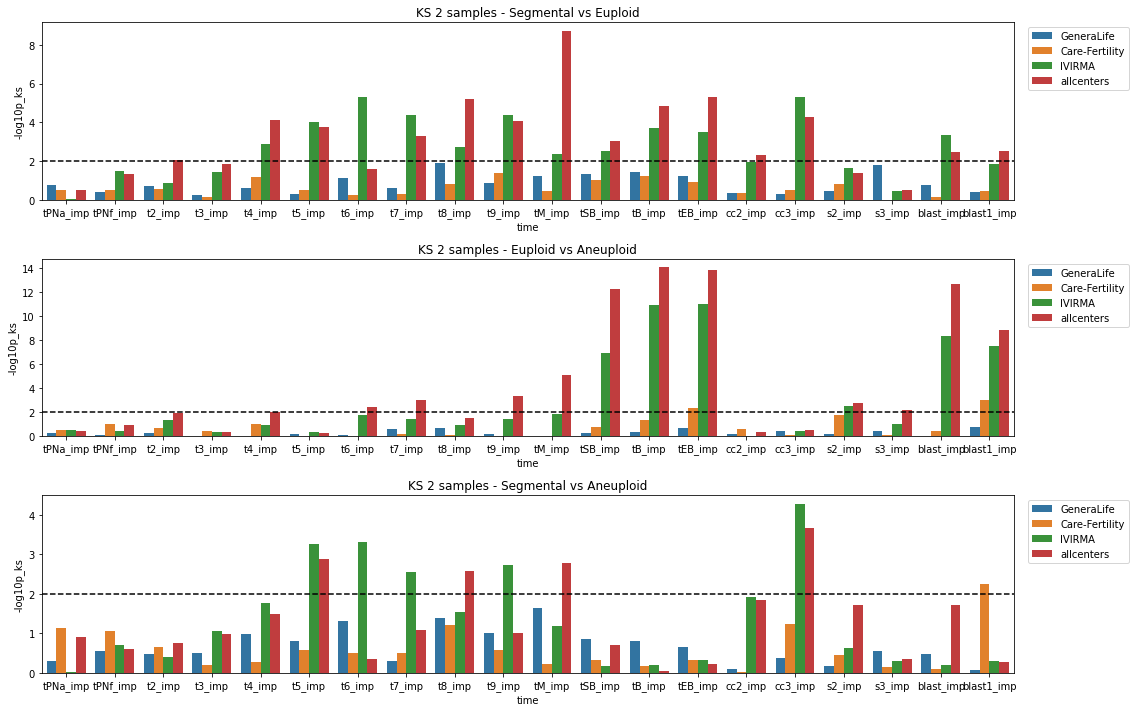

In [139]:
fig,ax = plt.subplots(3,1,figsize=(16,10))
ax[0].set_title('KS 2 samples - Segmental vs Euploid')
sns.barplot(ax=ax[0],data=df_ks2[(df_ks2.c1=='segm')&(df_ks2.c2=='eup')],x='time',y='-log10p_ks',hue='center')
ax[1].set_title('KS 2 samples - Euploid vs Aneuploid')
sns.barplot(ax=ax[1],data=df_ks2[(df_ks2.c1=='eup')&(df_ks2.c2=='aneup')],x='time',y='-log10p_ks',hue='center')
ax[2].set_title('KS 2 samples - Segmental vs Aneuploid')
sns.barplot(ax=ax[2],data=df_ks2[(df_ks2.c1=='segm')&(df_ks2.c2=='aneup')],x='time',y='-log10p_ks',hue='center')


ax[0].axhline(2,c='k',ls='--')
ax[1].axhline(2,c='k',ls='--')
ax[2].axhline(2,c='k',ls='--')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir,'significancy_ks_centers.jpeg'))

In [140]:
display(df_ks2.c1.unique())
display(df_ks2.c2.unique())

array(['eup', 'segm'], dtype=object)

array(['aneup', 'eup'], dtype=object)

#### Sibling analysis

In [141]:
df_pairs = pd.merge(df_processed_all, df_processed_all, on=['centre_ID','treatment_ID','patient_ID'],suffixes=['_x','_y'])
df_pairs = df_pairs[df_pairs['class_x']>df_pairs['class_y']]

In [142]:
df_pairs.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID_x,classification_x,tPB2_x,tPNa_x,tPNf_x,t2_x,t3_x,t4_x,t5_x,t6_x,t7_x,t8_x,t9_x,tSC_x,tM_x,tSB_x,tB_x,tEB_x,Sample ID_x,class_x,escope cose_well_x,center ID_x,Molecular Karyotype_x,note _x,operators' grading_x,date_x,IDA Score_x,grading_grouped_x,grading_grouped_num_x,tHB_x,index_x,ID_Ciclo_x,ID_Emb_x,IDCoppia_x,ID_Ciclo.1_x,Ciclo_x,IDCiclo_Link_x,Well_x,(inst/slide)_x,slide_Well_x,Diagnosi_x,segmental NY_x,"eup, aneup, segm, segm+aneup_x",Maternal Age_x,check_x,Duplicato_x,Control\nGroup _x,Case\nGroup_x,tBP2_x,tPNA_x,tPNF_x,tTM_x,tE_x,tHN_x,tHD_x,Psyn\nt2-PNf_x,s2\nt4-t3_x,s3\nt8-t5_x,ECC1\nt2-tPB2_x,cc2a\nt3-t2_x,cc2b\nt4-t2_x,cc3a\nt5-t4_x,cc3b\nt6-t4_x,cc3c\nt7-t4_x,cc3d\nt8-t4_x,ECC2\nt4-t2_x,ECC3\nt8-t4_x,Blastocyst Contraction_x,tPNa_missing_x,tPNf_missing_x,t2_missing_x,t3_missing_x,...,QC_NUM_MISSING_y,FLAG_QC_NUM_MISSING_y,FLAG_QC_NOT_MONOTONY_y,FLAG_QC_MISSING_BLASTO_y,t0_y,tmax_y,tPNa_imp_y,tPNf_imp_y,t2_imp_y,t3_imp_y,t4_imp_y,t5_imp_y,t6_imp_y,t7_imp_y,t8_imp_y,t9_imp_y,tM_imp_y,tSB_imp_y,tB_imp_y,tEB_imp_y,cc2_y,cc3_y,s2_y,s3_y,blast_y,blast1_y,cc2_imp_y,cc3_imp_y,s2_imp_y,s3_imp_y,blast_imp_y,blast1_imp_y,tPNf_ind_y,t2_ind_y,t3_ind_y,t4_ind_y,t5_ind_y,t6_ind_y,t7_ind_y,t8_ind_y,t9_ind_y,tSB_ind_y,tB_ind_y,tEB_ind_y,is_GeneraLife_y,is_IVIRMA_y,is_Care-Fertility_y,tPNa_imp_z_y,tPNf_imp_z_y,t2_imp_z_y,t3_imp_z_y,t4_imp_z_y,t5_imp_z_y,t6_imp_z_y,t7_imp_z_y,t8_imp_z_y,t9_imp_z_y,tM_imp_z_y,tSB_imp_z_y,tB_imp_z_y,tEB_imp_z_y,cc2_imp_z_y,cc3_imp_z_y,s2_imp_z_y,s3_imp_z_y,blast_imp_z_y,blast1_imp_z_y,pca_ll_y,pca1_y,pca2_y,FLAG_QC_PCA_y,FLAG_QC_y,QC_REASON_y,ritardo_max_y,ritardo_min_y
1,GeneraLife,7740,2,1,eup,NaN,7.135,23.499,26.001,38.008,39.259,53.767,65.774,71.026,83.612,83.862,NaN,86.615,118.202,198.703,NaN,7740_1.2,eup,D2015.11.14_S1384_I141_1,roma,euploid,la data corretta e' 20/03/2013,CC,2013-03-20,2.030342,"CC,BC,CB",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,6,True,False,True,0,1000,19.392,37.511,42.762,43.012,61.024,61.274,96.468,96.718,100.225332,111.762771,126.773704,137.145721,143.851776,148.468042,0.250,18.262,18.012,NaN,NaN,NaN,0.250,18.262,18.012,38.951332,94.383721,6.706055,18.119,5.251,0.250,18.012,0.250,35.194,0.250,3.507332,11.537438,10.372017,6.706055,4.616267,True,False,False,4.873163,3.783025,4.202422,1.313693,4.299072,1.697001,5.187914,4.398451,3.818011,4.080627,3.969467,3.931089,3.673052,3.622733,-2.872553,1.185783,4.837687,3.311892,2.378850,-0.208043,-88.919897,14.268518,0.731079,True,True,too many missing times;missing blasto times;lo...,4.837687,-2.872553
8,GeneraLife,7740,2,5,seg,NaN,7.500,24.200,NaN,30.600,39.900,40.200,53.700,54.200,55.900,75.100,NaN,93.600,109.400,118.100,122.6,7740_5.2,segm,D2015.11.14_S1384_I141_5,roma,+16q,NaN,-,2013-03-20,1.828950,-,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,...,1,False,False,False,0,1000,7.135,23.499,26.001,38.008,39.259,53.767,65.774,71.026,83.612000,83.862000,86.615000,118.202000,198.703000,203.023514,12.007,15.759,1.251,29.845,92.201,80.501,12.007,15.759,1.251,29.845000,92.201000,80.501000,16.364,2.502,12.007,1.251,14.508,12.007,5.252,12.586000,0.250000,31.587000,80.501000,4.320514,True,False,False,-0.719694,0.010406,-0.013214,0.339579,0.200416,0.667829,1.474970,1.613007,2.244881,1.237601,-0.067649,2.010122,8.997259,8.910567,0.518252,0.658594,-0.204610,2.232563,2.143456,16.371154,-390.593767,8.124037,6.852161,True,True,low pca likelihood;,2.232563,-0.204610
9,GeneraLife,7740,2,5,seg,NaN,7.500,24.200,NaN,30.600,39.900,40.200,53.700,54.200,55.900,75.100,NaN,93.600,109.400,118.100,122.6,7740_5.2,segm,D2015.11.14_S1384_I141_5,roma,+16q,NaN,-,2013-03-20,1.828950,-,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [143]:
for time in tl_all.imputed_times:
    df_pairs[time + '_delta'] = df_pairs[time + '_y'] - df_pairs[time + '_x']
    df_pairs[time + '_binary'] = df_pairs[time + '_y'] - df_pairs[time + '_x'] > 0
display(df_pairs.centre_ID.value_counts())

IVIRMA            6630
Care-Fertility     912
GeneraLife         528
roma_unblind       349
bologna             50
Name: centre_ID, dtype: int64

In [144]:
df_pairs.groupby(['centre_ID','class_x','class_y'])[['patient_ID']].count()

patient_ID
centre_ID      class_x    class_y            
Care-Fertility eup        aneup            57
               segm       aneup           162
                          eup             316
               segm+aneup aneup           146
                          eup             166
                          segm             65
GeneraLife     eup        aneup           194
               segm       aneup            73
                          eup              75
               segm+aneup aneup            93
                          eup              85
                          segm              8
IVIRMA         eup        aneup          4565
               segm       aneup           537
                          eup             869
               segm+aneup aneup           283
                          eup             321
                          segm             55
bologna        eup        aneup             8
               segm       aneup             3
                          eup              28
               segm+aneup aneup             2
                          eup               9
roma_unblind   eup        aneup           308
               segm       aneup             4
                          eup               4
               segm+aneup aneup            16
                          eup              17

In [145]:
df_pairs.loc[(df_pairs['class_x']==c1)&(df_pairs['class_y']==c2)]

,centre_ID,patient_ID,treatment_ID,embryo_ID_x,classification_x,tPB2_x,tPNa_x,tPNf_x,t2_x,t3_x,t4_x,t5_x,t6_x,t7_x,t8_x,t9_x,tSC_x,tM_x,tSB_x,tB_x,tEB_x,Sample ID_x,class_x,escope cose_well_x,center ID_x,Molecular Karyotype_x,note _x,operators' grading_x,date_x,IDA Score_x,grading_grouped_x,grading_grouped_num_x,tHB_x,index_x,ID_Ciclo_x,ID_Emb_x,IDCoppia_x,ID_Ciclo.1_x,Ciclo_x,IDCiclo_Link_x,Well_x,(inst/slide)_x,slide_Well_x,Diagnosi_x,segmental NY_x,"eup, aneup, segm, segm+aneup_x",Maternal Age_x,check_x,Duplicato_x,Control\nGroup _x,Case\nGroup_x,tBP2_x,tPNA_x,tPNF_x,tTM_x,tE_x,tHN_x,tHD_x,Psyn\nt2-PNf_x,s2\nt4-t3_x,s3\nt8-t5_x,ECC1\nt2-tPB2_x,cc2a\nt3-t2_x,cc2b\nt4-t2_x,cc3a\nt5-t4_x,cc3b\nt6-t4_x,cc3c\nt7-t4_x,cc3d\nt8-t4_x,ECC2\nt4-t2_x,ECC3\nt8-t4_x,Blastocyst Contraction_x,tPNa_missing_x,tPNf_missing_x,t2_missing_x,t3_missing_x,...,t9_ind_y,tSB_ind_y,tB_ind_y,tEB_ind_y,is_GeneraLife_y,is_IVIRMA_y,is_Care-Fertility_y,tPNa_imp_z_y,tPNf_imp_z_y,t2_imp_z_y,t3_imp_z_y,t4_imp_z_y,t5_imp_z_y,t6_imp_z_y,t7_imp_z_y,t8_imp_z_y,t9_imp_z_y,tM_imp_z_y,tSB_imp_z_y,tB_imp_z_y,tEB_imp_z_y,cc2_imp_z_y,cc3_imp_z_y,s2_imp_z_y,s3_imp_z_y,blast_imp_z_y,blast1_imp_z_y,pca_ll_y,pca1_y,pca2_y,FLAG_QC_PCA_y,FLAG_QC_y,QC_REASON_y,ritardo_max_y,ritardo_min_y,tPNa_imp_delta,tPNa_imp_binary,tPNf_imp_delta,tPNf_imp_binary,t2_imp_delta,t2_imp_binary,t3_imp_delta,t3_imp_binary,t4_imp_delta,t4_imp_binary,t5_imp_delta,t5_imp_binary,t6_imp_delta,t6_imp_binary,t7_imp_delta,t7_imp_binary,t8_imp_delta,t8_imp_binary,t9_imp_delta,t9_imp_binary,tM_imp_delta,tM_imp_binary,tSB_imp_delta,tSB_imp_binary,tB_imp_delta,tB_imp_binary,tEB_imp_delta,tEB_imp_binary,cc2_imp_delta,cc2_imp_binary,cc3_imp_delta,cc3_imp_binary,s2_imp_delta,s2_imp_binary,s3_imp_delta,s3_imp_binary,blast_imp_delta,blast_imp_binary,blast1_imp_delta,blast1_imp_binary


In [146]:
df_sibling = pd.DataFrame()

dataset_dict = {'GeneraLife':df_roma_processed,'Care-Fertility':df_uk_processed,'IVIRMA':df_valencia_processed,'allcenters':df_all_processed}

for center in dataset_dict.keys():
    dataset = dataset_dict[center]
    df_pairs = pd.merge(dataset,dataset,on=['centre_ID','treatment_ID','patient_ID'],suffixes=['_x','_y'])
    df_pairs = df_pairs[df_pairs['class_x']!=df_pairs['class_y']]
    for time in tl_all.imputed_times:
        time_delta = time+'_delta'
        df_pairs[time_delta] = df_pairs[time+'_y'] - df_pairs[time+'_x']
        df_pairs[time+'_binary'] = df_pairs[time+'_y'] - df_pairs[time+'_x'] > 0
    
        for c1 in ['eup','segm','aneup']:
            for c2 in ['eup','segm','aneup']:
                if 1==1:#c1 > c2:
                    df_sel = df_pairs.loc[(df_pairs['class_x']==c1)&(df_pairs['class_y']==c2)]
                    if len(df_sel)>0:

                        list1 = df_sel[time_delta].dropna()
                        n_success = (list1>0).sum()
                        avg_delay = np.mean(list1)
                        n_trials = len(list1)
                        frac_binary = n_success/n_trials -0.5
                        list_zero = np.zeros(n_trials)

                        pvalue_bin = stats.binom_test(n_success, n=n_trials, p=0.5, alternative='two-sided')
                        statistic, pvalue_wilcoxon = stats.wilcoxon(list1,list_zero)
                        


                        df_sibling = df_sibling.append({'center':center,'c1':c1,'c2':c2,'time':time,'avg_delay':avg_delay,
                                                              'pvalue_bin':pvalue_bin,'pvalue_wilcoxon':pvalue_wilcoxon,'frac_binary':frac_binary},ignore_index=True)


df_sibling['-log10p_bin'] = -np.log10(df_sibling['pvalue_bin'])
df_sibling['-log10p_wil'] = -np.log10(df_sibling['pvalue_wilcoxon'])

In [147]:
df_sibling

,avg_delay,c1,c2,center,frac_binary,pvalue_bin,pvalue_wilcoxon,time,-log10p_bin,-log10p_wil
0,-0.638717,eup,segm,GeneraLife,-0.073333,2.480457e-01,3.176329e-01,tPNa_imp,0.605468,0.498075
1,-0.256859,eup,aneup,GeneraLife,-0.030928,4.297475e-01,6.156943e-01,tPNa_imp,0.366787,0.210635
2,0.638717,segm,eup,GeneraLife,0.060000,3.556992e-01,3.176329e-01,tPNa_imp,0.448917,0.498075
3,1.216515,segm,aneup,GeneraLife,0.171233,4.626294e-03,2.321721e-03,tPNa_imp,2.334767,2.634190
4,0.256859,aneup,eup,GeneraLife,0.005155,9.427890e-01,6.156943e-01,tPNa_imp,0.025585,0.210635
...,...,...,...,...,...,...,...,...,...,...
475,0.345331,eup,aneup,allcenters,0.034684,7.145351e-07,3.641051e-11,blast1_imp,6.145976,10.438773
476,0.013846,segm,eup,allcenters,-0.004644,7.595968e-01,5.773171e-01,blast1_imp,0.119417,0.238586
477,0.452392,segm,aneup,allcenters,0.037869,3.763532e-02,1.735101e-03,blast1_imp,1.424404,2.760675
478,-0.345331,aneup,eup,allcenters,-0.034879,6.185863e-07,3.641051e-11,blast1_imp,6.208600,10.438773


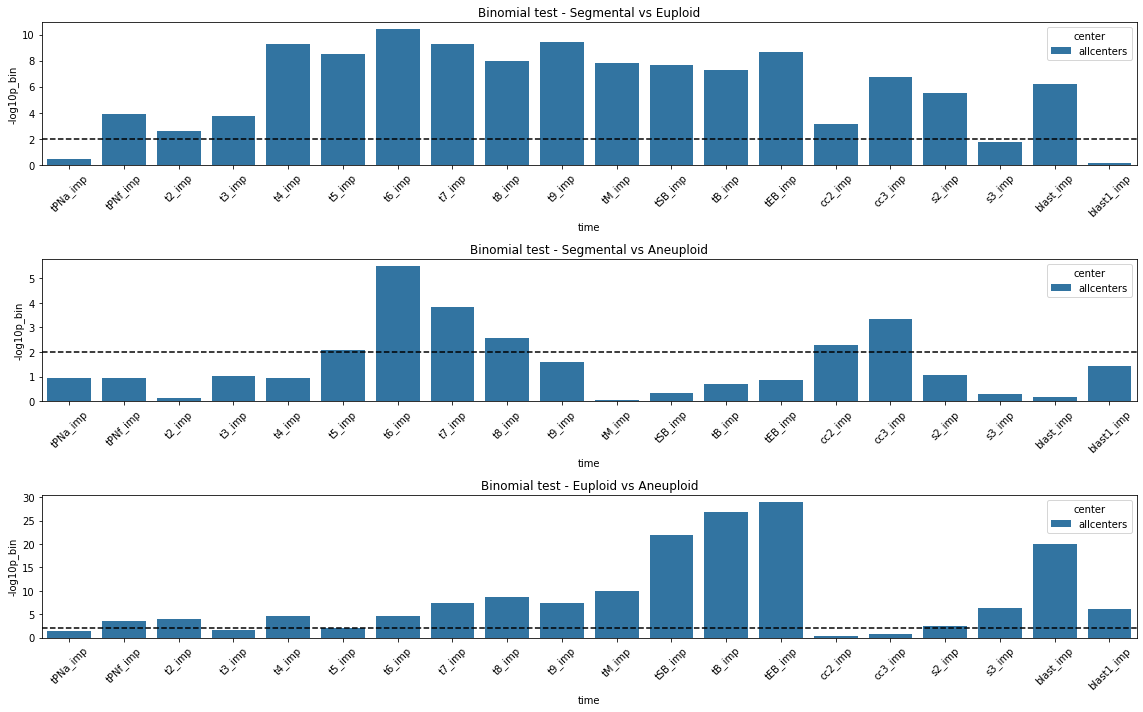

In [153]:
fig,ax = plt.subplots(3,1,figsize=(16,10))
ax[0].set_title('Binomial test - Segmental vs Euploid')
sns.barplot(ax=ax[0],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='eup')],x='time',y='-log10p_bin',hue='center',hue_order=['allcenters'])
ax[1].set_title('Binomial test - Segmental vs Aneuploid')
sns.barplot(ax=ax[1],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='aneup')],x='time',y='-log10p_bin',hue='center',hue_order=['allcenters'])
ax[2].set_title('Binomial test - Euploid vs Aneuploid')
sns.barplot(ax=ax[2],data=df_sibling[(df_sibling.c1=='eup')&(df_sibling.c2=='aneup')],x='time',y='-log10p_bin',hue='center',hue_order=['allcenters'])

ax[0].axhline(2,c='k',ls='--')
ax[1].axhline(2,c='k',ls='--')
ax[2].axhline(2,c='k',ls='--')
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
#plt.title('Binomial test - ')
plt.show()
# plt.savefig(os.path.join(output_dir,'significancy_sibling_bin.jpeg'))

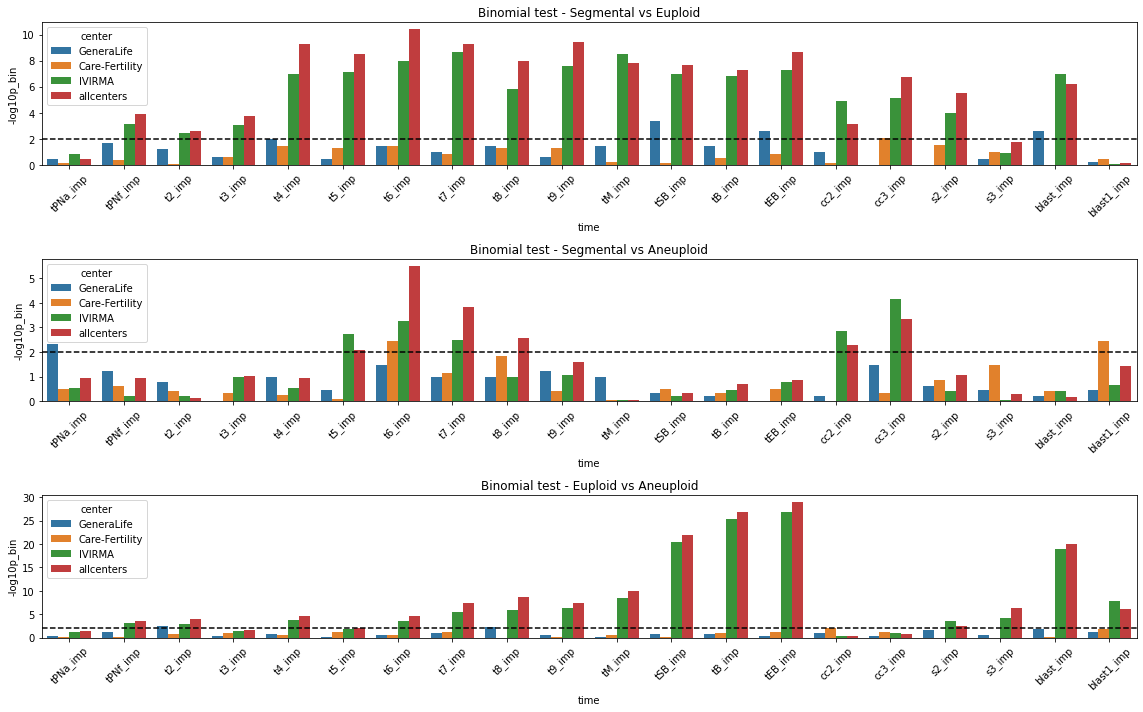

In [152]:
fig,ax = plt.subplots(3,1,figsize=(16,10))
plt.title('Significancy binomial test')
ax[0].set_title('Binomial test - Segmental vs Euploid')
sns.barplot(ax=ax[0],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='eup')],x='time',y='-log10p_bin',hue='center')
ax[1].set_title('Binomial test - Segmental vs Aneuploid')
sns.barplot(ax=ax[1],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='aneup')],x='time',y='-log10p_bin',hue='center')
ax[2].set_title('Binomial test - Euploid vs Aneuploid')
sns.barplot(ax=ax[2],data=df_sibling[(df_sibling.c1=='eup')&(df_sibling.c2=='aneup')],x='time',y='-log10p_bin',hue='center')
ax[0].axhline(2,c='k',ls='--')
ax[1].axhline(2,c='k',ls='--')
ax[2].axhline(2,c='k',ls='--')
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(output_dir,'significancy_siblings_centers_bin.jpeg'))

##### Wilcoxon signed-rank test

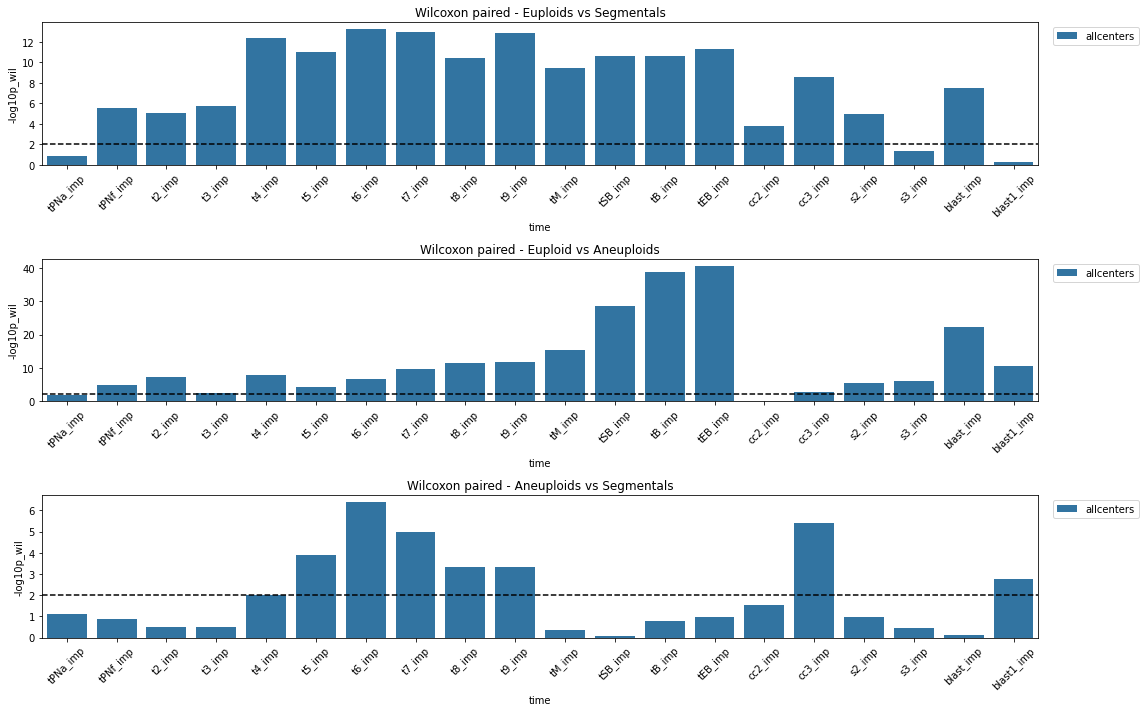

In [151]:
fig,ax = plt.subplots(3,1,figsize=(16,10))
ax[0].set_title('Wilcoxon paired - Euploids vs Segmentals')
sns.barplot(ax=ax[0],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='eup')],x='time',y='-log10p_wil',hue='center',hue_order=['allcenters'])
ax[1].set_title('Wilcoxon paired - Euploid vs Aneuploids')
sns.barplot(ax=ax[1],data=df_sibling[(df_sibling.c1=='eup')&(df_sibling.c2=='aneup')],x='time',y='-log10p_wil',hue='center',hue_order=['allcenters'])
ax[2].set_title('Wilcoxon paired - Aneuploids vs Segmentals')
sns.barplot(ax=ax[2],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='aneup')],x='time',y='-log10p_wil',hue='center',hue_order=['allcenters'])

ax[0].axhline(2,c='k',ls='--')
ax[1].axhline(2,c='k',ls='--')
ax[2].axhline(2,c='k',ls='--')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
#plt.ylim([0,15])
plt.show()
#plt.savefig(os.path.join(output_dir,'significancy_sibling_tind.jpeg'))

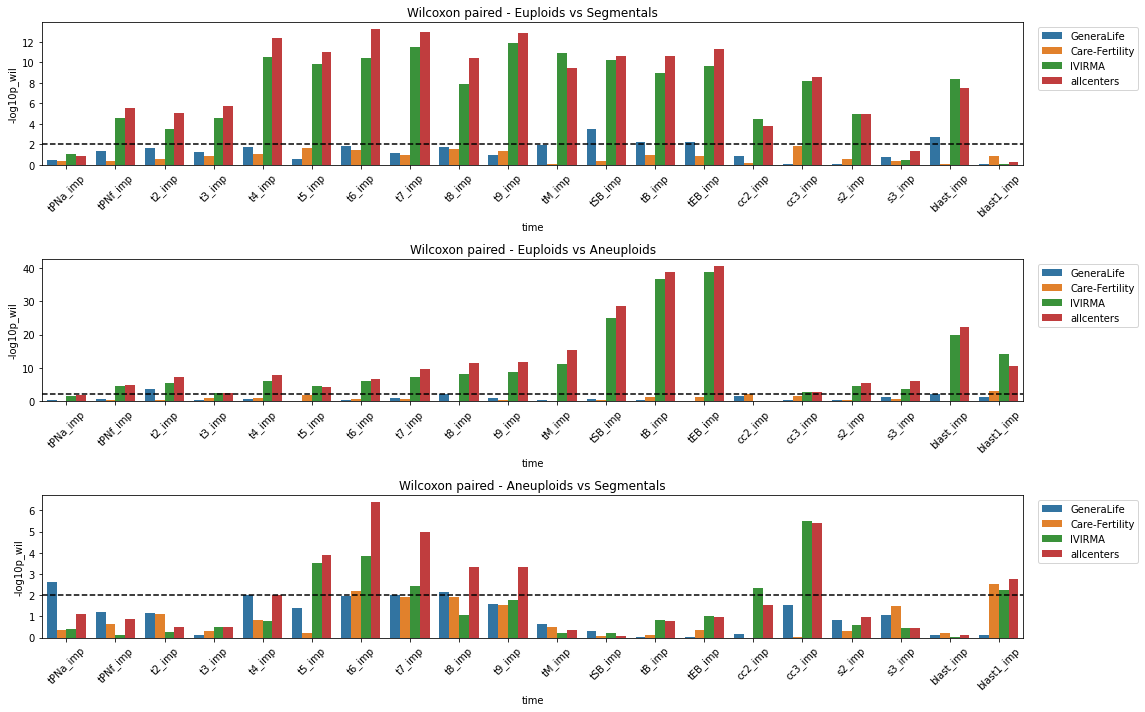

In [157]:
fig,ax = plt.subplots(3,1,figsize=(16,10))
ax[0].set_title('Wilcoxon paired - Euploids vs Segmentals')
sns.barplot(ax=ax[0],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='eup')],x='time',y='-log10p_wil',hue='center')
ax[1].set_title('Wilcoxon paired - Euploids vs Aneuploids')
sns.barplot(ax=ax[1],data=df_sibling[(df_sibling.c1=='eup')&(df_sibling.c2=='aneup')],x='time',y='-log10p_wil',hue='center')
ax[2].set_title('Wilcoxon paired - Aneuploids vs Segmentals')
sns.barplot(ax=ax[2],data=df_sibling[(df_sibling.c1=='segm')&(df_sibling.c2=='aneup')],x='time',y='-log10p_wil',hue='center')


ax[0].axhline(2,c='k',ls='--')
ax[1].axhline(2,c='k',ls='--')
ax[2].axhline(2,c='k',ls='--')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
ax[2].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()
#plt.savefig(os.path.join(output_dir,'significancy_siblings_centers_tind.jpeg'))

In [127]:
df_sibling

,avg_delay,c1,c2,center,frac_binary,pvalue_bin,pvalue_wilcoxon,time,-log10p_bin,-log10p_wil
0,-0.638717,eup,segm,GeneraLife,-0.073333,2.480457e-01,3.176329e-01,tPNa_imp,0.605468,0.498075
1,-0.256859,eup,aneup,GeneraLife,-0.030928,4.297475e-01,6.156943e-01,tPNa_imp,0.366787,0.210635
2,0.638717,segm,eup,GeneraLife,0.060000,3.556992e-01,3.176329e-01,tPNa_imp,0.448917,0.498075
3,1.216515,segm,aneup,GeneraLife,0.171233,4.626294e-03,2.321721e-03,tPNa_imp,2.334767,2.634190
4,0.256859,aneup,eup,GeneraLife,0.005155,9.427890e-01,6.156943e-01,tPNa_imp,0.025585,0.210635
...,...,...,...,...,...,...,...,...,...,...
475,0.345331,eup,aneup,allcenters,0.034684,7.145351e-07,3.641051e-11,blast1_imp,6.145976,10.438773
476,0.013846,segm,eup,allcenters,-0.004644,7.595968e-01,5.773171e-01,blast1_imp,0.119417,0.238586
477,0.452392,segm,aneup,allcenters,0.037869,3.763532e-02,1.735101e-03,blast1_imp,1.424404,2.760675
478,-0.345331,aneup,eup,allcenters,-0.034879,6.185863e-07,3.641051e-11,blast1_imp,6.208600,10.438773


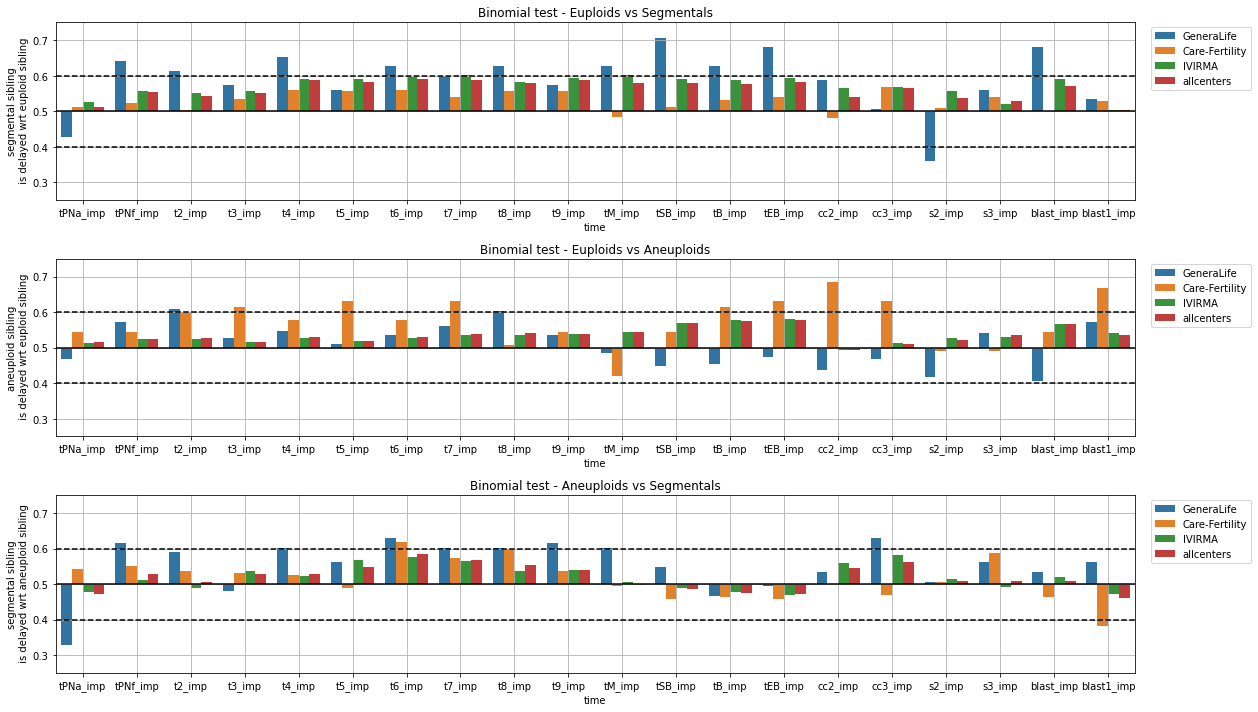

In [126]:
fig,ax = plt.subplots(3,1,figsize=(16,10),sharey=True)
ax[0].set_title('Binomial test - Euploids vs Segmentals')
sns.barplot(ax=ax[0],data=df_sibling[(df_sibling.c1=='eup')&(df_sibling.c2=='segm')],x='time',y='frac_binary',hue='center')
ax[1].set_title('Binomial test - Euploids vs Aneuploids')
sns.barplot(ax=ax[1],data=df_sibling[(df_sibling.c1=='eup')&(df_sibling.c2=='aneup')],x='time',y='frac_binary',hue='center')
ax[2].set_title('Binomial test - Aneuploids vs Segmentals')
sns.barplot(ax=ax[2],data=df_sibling[(df_sibling.c1=='aneup')&(df_sibling.c2=='segm')],x='time',y='frac_binary',hue='center')

ax[0].axhline(.0,c='k',ls='-')
ax[1].axhline(.0,c='k',ls='-')
ax[2].axhline(.0,c='k',ls='-')

ax[0].axhline(.1,c='k',ls='--')
ax[1].axhline(.1,c='k',ls='--')
ax[2].axhline(.1,c='k',ls='--')

ax[0].axhline(-0.1,c='k',ls='--')
ax[1].axhline(-0.1,c='k',ls='--')
ax[2].axhline(-0.1,c='k',ls='--')
plt.tight_layout()
plt.ylim([-0.25,0.25])
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_yticks([-0.2,-0.1,0,0.1,0.2])
ax[0].set_yticklabels([0.3,0.4,0.5,0.6,0.7])
ax[1].set_yticks([-0.2,-0.1,0,0.1,0.2])
ax[1].set_yticklabels([0.3,0.4,0.5,0.6,0.7])
ax[2].set_yticks([-0.2,-0.1,0,0.1,0.2])
ax[2].set_yticklabels([0.3,0.4,0.5,0.6,0.7])
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].set_ylabel('segmental sibling\n is delayed wrt euploid sibling')
ax[1].set_ylabel('aneuploid sibling\n is delayed wrt euploid sibling')
ax[2].set_ylabel('segmental sibling\n is delayed wrt aneuploid sibling')
plt.show()
#plt.savefig(os.path.join(output_dir,'significancy_siblings_centers_frac.jpeg'))

#### Defining training and test sets
1. test 40%
2. training 60%

In [158]:
df_roma_train0, df_roma_test0 = train_test_split(df_roma[df_roma['class'].isin(['segm','eup'])], test_size=0.4,random_state=104)
df_roma_train = df_roma_train0.copy()
df_roma_test = df_roma_test0.copy()

In [159]:
display(df_roma_train.shape)
display(df_roma_test.shape)

(128, 76)

(56, 76)

In [163]:
df_val_train0, df_val_test0 = train_test_split(df_valencia[df_valencia['class'].isin(['segm','eup'])], test_size=0.4,random_state=104)
df_val_train = df_val_train0.copy()
df_val_test = df_val_test0.copy()

In [164]:
display(df_val_train.shape[0])
display(df_val_test.shape[0])

2029

870

In [165]:
df_uk_train0, df_uk_test0 = train_test_split(df_uk[df_uk['class'].isin(['segm','eup'])], test_size=0.4,random_state=104)
df_uk_train = df_uk_train0.copy()
df_uk_test = df_uk_test0.copy()

In [166]:
display(df_uk_train.shape[0])
display(df_uk_test.shape[0])

457

197

In [167]:
df_all_train = pd.concat([df_roma_train, df_val_train, df_uk_train])
df_all_test = pd.concat([df_roma_test, df_val_test, df_uk_test])

In [168]:
#1 train 4 models: model specific and global model
tl_roma = TimeLapseAnalyzer()
tl_roma.train(df_roma_train.copy(), model_feature_list = selected_feature_list + ['ritardo_max','ritardo_min','pca_ll'], target='is_segmental')
tl_val = TimeLapseAnalyzer()
tl_val.train(df_val_train.copy(), model_feature_list = selected_feature_list + ['ritardo_max','ritardo_min','pca_ll'], target='is_segmental')
tl_uk = TimeLapseAnalyzer()
tl_uk.train(df_uk_train.copy(), model_feature_list = selected_feature_list + ['ritardo_max','ritardo_min','pca_ll'], target='is_segmental')
tl_all = TimeLapseAnalyzer(PCA_LL_TH=-80)
tl_all.train(df_all_train.copy(), model_feature_list = selected_feature_list + ['ritardo_max','ritardo_min','pca_ll'], target='is_segmental')

In [169]:
df_roma_processed = tl_roma.process_data(df_roma, train=False)
df_uk_processed = tl_uk.process_data(df_uk, train=False)
df_valencia_processed = tl_roma.process_data(df_valencia, train=False)
df_all_processed = tl_all.process_data(df_all, train=False)

In [170]:
df_roma_processed.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,classification,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,Sample ID,class,escope cose_well,center ID,Molecular Karyotype,note,operators' grading,date,IDA Score,grading_grouped,grading_grouped_num,QC_NUM_MISSING,FLAG_QC_NUM_MISSING,FLAG_QC_NOT_MONOTONY,FLAG_QC_MISSING_BLASTO,t0,tmax,tPNa_imp,tPNf_imp,t2_imp,t3_imp,t4_imp,t5_imp,t6_imp,t7_imp,t8_imp,t9_imp,tM_imp,tSB_imp,tB_imp,tEB_imp,cc2,cc3,s2,s3,blast,blast1,cc2_imp,cc3_imp,s2_imp,s3_imp,blast_imp,blast1_imp,tPNf_ind,t2_ind,t3_ind,t4_ind,t5_ind,t6_ind,t7_ind,t8_ind,t9_ind,tSB_ind,tB_ind,tEB_ind,tPNa_imp_z,tPNf_imp_z,t2_imp_z,t3_imp_z,t4_imp_z,t5_imp_z,t6_imp_z,t7_imp_z,t8_imp_z,t9_imp_z,tM_imp_z,tSB_imp_z,tB_imp_z,tEB_imp_z,cc2_imp_z,cc3_imp_z,s2_imp_z,s3_imp_z,blast_imp_z,blast1_imp_z,pca_ll,pca1,pca2,FLAG_QC_PCA,FLAG_QC,QC_REASON,ritardo_max,ritardo_min
0,GeneraLife,7740,2,1,eup,NaN,7.135,23.499,26.001,38.008,39.259,53.767,65.774,71.026,83.612,83.862,NaN,86.615,118.202,198.703,NaN,7740_1.2,eup,D2015.11.14_S1384_I141_1,roma,euploid,la data corretta e' 20/03/2013,CC,2013-03-20,2.030342,"CC,BC,CB",3,1,False,False,False,0,1000,7.135,23.499,26.001000,38.008,39.259,53.767,65.774,71.026,83.61200,83.86200,86.615000,118.202000,198.703000,205.444103,12.007,15.759,1.251,29.845,92.201,80.501,12.007000,15.759,1.251,29.84500,92.201000,80.501000,16.364,2.502000,12.007000,1.251,14.508,12.007,5.252,12.58600,0.25000,31.587000,80.501000,6.741103,-0.652309,-0.231151,-0.423177,0.246604,-0.131427,0.604296,1.565803,0.898491,1.339067,0.775043,0.218546,1.321361,6.680655,6.397700,0.579671,0.624327,-0.357409,1.038613,1.403321,9.557462,-179.313052,4.825022,3.146139,True,True,low pca likelihood;,1.038613,-0.357409
1,GeneraLife,7740,2,2,ane,NaN,19.392,37.511,42.762,43.012,61.024,61.274,96.468,96.718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7740_2.2,aneup,D2015.11.14_S1384_I141_2,roma,+22,NaN,CC,2013-03-20,1.828950,"CC,BC,CB",3,6,True,False,True,0,1000,19.392,37.511,42.762000,43.012,61.024,61.274,96.468,96.718,101.52536,109.96159,119.985584,134.887286,145.841937,153.027746,0.250,18.262,18.012,NaN,NaN,NaN,0.250000,18.262,18.012,40.25136,92.125286,10.954651,18.119,5.251000,0.250000,18.012,0.250,35.194,0.250,4.80736,8.43623,14.901702,10.954651,7.185809,4.333633,4.255090,4.912822,1.250144,2.999900,1.489351,5.313593,2.815027,2.596924,2.696340,2.755699,2.488647,2.665477,2.553785,-2.083656,1.025432,2.437772,1.813711,1.398066,-0.066578,-71.305331,10.664967,-2.574290,True,True,too many missing times;missing blasto times;lo...,2.437772,-2.083656
2,GeneraLife,7740,2,5,seg,NaN,7.500,24.200,NaN,30.600,39.900,40.200,53.700,54.200,55.900,75.100,NaN,93.600,109.400,118.100,122.6,7740_5.2,segm,D2015.11.14_S1384_I141_5,roma,+16q,NaN,-,2013-03-20,1.828950,-,4,1,False,False,False,0,1000,7.500,24.200,25.766232,30.600,39.900,40.200,53.700,54.200,55.90000,75.10000,93.600000,109.400000,118.100000,122.600000,NaN,9.600,9.300,15.700,NaN,8.700,4.833768,9.600,9.300,15.70000,83.633768,8.700000,16.700,1.566232,4.833768,9.300,0.300,13.500,0.500,1.70000,19.20000,15.800000,8.700000,4.500000,-0.503833,-0.006711,-0.497918,-1.239053,-0.039206,-0.995217,0.091547,-0.356672,-0.606840,0.130036,0.749613,0.705582,0.558277,0.322389,-1.045290,-0.362652,0.984898,-0.014950,0.808642,-0.378584,-19.711185,0.074111,1.513494,False,False,,0.984898,-1.045290


In [171]:
df_uk_processed.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,classification,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,tHB,class,QC_NUM_MISSING,FLAG_QC_NUM_MISSING,FLAG_QC_NOT_MONOTONY,FLAG_QC_MISSING_BLASTO,t0,tmax,tPNa_imp,tPNf_imp,t2_imp,t3_imp,t4_imp,t5_imp,t6_imp,t7_imp,t8_imp,t9_imp,tM_imp,tSB_imp,tB_imp,tEB_imp,cc2,cc3,s2,s3,blast,blast1,cc2_imp,cc3_imp,s2_imp,s3_imp,blast_imp,blast1_imp,tPNf_ind,t2_ind,t3_ind,t4_ind,t5_ind,t6_ind,t7_ind,t8_ind,t9_ind,tSB_ind,tB_ind,tEB_ind,tPNa_imp_z,tPNf_imp_z,t2_imp_z,t3_imp_z,t4_imp_z,t5_imp_z,t6_imp_z,t7_imp_z,t8_imp_z,t9_imp_z,tM_imp_z,tSB_imp_z,tB_imp_z,tEB_imp_z,cc2_imp_z,cc3_imp_z,s2_imp_z,s3_imp_z,blast_imp_z,blast1_imp_z,pca_ll,pca1,pca2,FLAG_QC_PCA,FLAG_QC,QC_REASON,ritardo_max,ritardo_min
0,Care-Fertility,101334,57136,0,seg,3.117706,6.621338,28.130989,31.633202,42.140834,42.638908,46.974684,54.812421,55.314975,56.646939,58.481107,90.996477,96.666114,102.001149,NaN,NaN,NaN,segm,2,False,False,True,0,1000,6.621338,28.130989,31.633202,42.140834,42.638908,46.974684,54.812421,55.314975,56.646939,58.481107,96.666114,102.001149,110.233771,115.061136,10.507632,4.833849,0.498073,9.672255,70.367947,NaN,10.507632,4.833849,0.498073,9.672255,70.367947,8.232622,21.509651,3.502213,10.507632,0.498073,4.335776,7.837737,0.502554,1.331963,1.834168,5.335035,8.232622,4.827365,-0.634655,1.155590,1.237795,1.175957,0.947144,-0.367482,0.346589,-0.007554,-0.331348,-1.275861,0.76930,0.381603,0.327263,0.294475,0.076801,-1.829001,-0.464970,-0.094992,-0.221267,-0.098106,-25.060578,0.814905,0.505168,False,True,missing blasto times;,0.076801,-1.829001
1,Care-Fertility,110535,55397,1,ane_seg,4.693487,9.364579,20.206004,23.601624,34.441532,38.110821,46.952163,51.622867,52.623023,64.140723,66.850828,NaN,93.263283,97.932211,106.103754,113.774470,NaN,segm+aneup,0,False,False,False,0,1000,9.364579,20.206004,23.601624,34.441532,38.110821,46.952163,51.622867,52.623023,64.140723,66.850828,93.263283,97.932211,106.103754,113.774470,10.839908,12.510631,3.669289,17.188560,74.330586,8.171543,10.839908,12.510631,3.669289,17.188560,74.330586,8.171543,10.841426,3.395620,10.839908,3.669289,8.841342,4.670704,1.000156,11.517700,2.710105,4.668928,8.171543,7.670716,0.725096,-0.869114,-0.641359,-0.460608,-0.068355,-0.370822,-0.150574,-0.359806,0.424015,-0.406107,0.43914,-0.070319,-0.123210,0.154828,0.182268,-0.076099,0.661430,0.786997,0.251511,-0.111868,-16.630418,-0.425191,-0.975088,False,False,,0.786997,-0.076099
2,Care-Fertility,110535,55397,2,ane_seg,3.531621,8.035138,25.608747,27.608386,39.452262,40.117197,52.125833,54.293604,54.293604,56.794494,71.221563,NaN,NaN,91.934280,99.938232,113.112612,NaN,segm+aneup,1,False,False,False,0,1000,8.035138,25.608747,27.608386,39.452262,40.117197,52.125833,54.293604,54.293604,56.794494,71.221563,84.632419,91.934280,99.938232,113.112612,11.843876,12.673571,0.664935,4.668661,64.325894,8.003952,11.843876,12.673571,0.664935,4.668661,64.325894,8.003952,17.573609,1.999639,11.843876,0.664935,12.008636,2.167771,0.000000,2.500890,14.427069,7.301862,8.003952,13.174381,0.066128,0.511199,0.296106,0.604474,0.381609,0.396513,0.265720,-0.141204,-0.316474,0.048085,-0.39827,-0.736486,-0.795701,0.082993,0.500933,-0.038893,-0.405701,-0.682132,-0.942137,-0.149630,-15.213829,-0.103899,1.807087,False,False,,0.500933,-0.682132


In [172]:
df_valencia_processed.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,tHB,classification,class,QC_NUM_MISSING,FLAG_QC_NUM_MISSING,FLAG_QC_NOT_MONOTONY,FLAG_QC_MISSING_BLASTO,t0,tmax,tPNa_imp,tPNf_imp,t2_imp,t3_imp,t4_imp,t5_imp,t6_imp,t7_imp,t8_imp,t9_imp,tM_imp,tSB_imp,tB_imp,tEB_imp,cc2,cc3,s2,s3,blast,blast1,cc2_imp,cc3_imp,s2_imp,s3_imp,blast_imp,blast1_imp,tPNf_ind,t2_ind,t3_ind,t4_ind,t5_ind,t6_ind,t7_ind,t8_ind,t9_ind,tSB_ind,tB_ind,tEB_ind,tPNa_imp_z,tPNf_imp_z,t2_imp_z,t3_imp_z,t4_imp_z,t5_imp_z,t6_imp_z,t7_imp_z,t8_imp_z,t9_imp_z,tM_imp_z,tSB_imp_z,tB_imp_z,tEB_imp_z,cc2_imp_z,cc3_imp_z,s2_imp_z,s3_imp_z,blast_imp_z,blast1_imp_z,pca_ll,pca1,pca2,FLAG_QC_PCA,FLAG_QC,QC_REASON,ritardo_max,ritardo_min
0,IVIRMA,24600086,1162530,11625302,4.691756,8.943418,22.656076,25.157386,35.914248,37.164727,44.922296,45.672729,51.069554,56.321618,72.520932,NaN,92.524525,110.175480,120.255914,NaN,NaN,ane,aneup,1,False,False,False,0,1000,8.943418,22.656076,25.157386,35.914248,37.164727,44.922296,45.672729,51.069554,56.321618,72.520932,92.524525,110.175480,120.255914,127.656972,10.756862,9.008048,1.250478,11.399322,85.018094,10.080434,10.756862,9.008048,1.250478,11.399322,85.018094,10.080434,13.712658,2.501310,10.756862,1.250478,7.757569,0.750433,5.396825,5.252064,16.199313,17.650956,10.080434,7.401058,0.083326,-0.501031,-0.691749,-0.173293,-0.432730,-0.438471,-0.888597,-0.590192,-0.577234,-0.059820,0.667845,0.759834,0.722034,0.693238,0.296476,-0.457512,-0.357496,-0.335278,0.904732,-0.187555,-16.678258,-0.191301,1.824122,False,False,,0.296476,-0.457512
1,IVIRMA,24600086,1162530,11625303,3.192638,7.194379,21.303973,23.658509,24.659033,32.663929,35.165776,42.670238,44.423722,56.074834,59.326616,NaN,81.525903,90.028877,98.924990,NaN,NaN,ane,aneup,1,False,False,False,0,1000,7.194379,21.303973,23.658509,24.659033,32.663929,35.165776,42.670238,44.423722,56.074834,59.326616,81.525903,90.028877,98.924990,106.505499,1.000524,10.506743,8.004896,20.909058,66.370368,8.896112,1.000524,10.506743,8.004896,20.909058,66.370368,8.896112,14.109594,2.354536,1.000524,8.004896,2.501847,7.504462,1.753483,11.651113,3.251781,8.502975,8.896112,7.580509,-0.628154,-0.933936,-1.168928,-2.430499,-1.080258,-1.588738,-1.255206,-1.085949,-0.594563,-1.031107,-0.168376,-0.649603,-0.898204,-0.857890,-1.913639,-0.217346,0.768918,0.373037,-0.389668,-0.351445,-23.841020,-3.364382,1.699350,False,False,,0.768918,-1.913639
2,IVIRMA,24600086,1162530,11625304,2.694258,6.947665,25.160933,27.663141,29.414341,38.420329,39.419396,53.073514,54.824809,58.827855,68.721377,NaN,87.279586,96.120639,102.426109,NaN,NaN,ane,aneup,1,False,False,False,0,1000,6.947665,25.160933,27.663141,29.414341,38.420329,39.419396,53.073514,54.824809,58.827855,68.721377,87.279586,96.120639,102.426109,109.977165,1.751200,10.005055,9.005988,19.408459,68.457498,6.305471,1.751200,10.005055,9.005988,19.408459,68.457498,6.305471,18.213268,2.502208,1.751200,9.005988,0.999067,13.654119,1.751294,4.003047,9.893522,8.841052,6.305471,7.551055,-0.728513,0.300952,0.105978,-1.476834,-0.252086,-1.087248,0.015052,-0.310063,-0.401249,-0.339521,0.269075,-0.223429,-0.632268,-0.603298,-1.743587,-0.297742,0.935867,0.261267,-0.244793,-0.709946,-22.348377,-1.181264,0.319091,False,False,,0.935867,-1.743587


In [173]:
df_all_processed.head(3)

,centre_ID,patient_ID,treatment_ID,embryo_ID,classification,tPB2,tPNa,tPNf,t2,t3,t4,t5,t6,t7,t8,t9,tSC,tM,tSB,tB,tEB,Sample ID,class,escope cose_well,center ID,Molecular Karyotype,note,operators' grading,date,IDA Score,grading_grouped,grading_grouped_num,tHB,index,ID_Ciclo,ID_Emb,IDCoppia,ID_Ciclo.1,Ciclo,IDCiclo_Link,Well,(inst/slide),slide_Well,Diagnosi,segmental NY,"eup, aneup, segm, segm+aneup",Maternal Age,check,Duplicato,Control\nGroup,Case\nGroup,tBP2,tPNA,tPNF,tTM,tE,tHN,tHD,Psyn\nt2-PNf,s2\nt4-t3,s3\nt8-t5,ECC1\nt2-tPB2,cc2a\nt3-t2,cc2b\nt4-t2,cc3a\nt5-t4,cc3b\nt6-t4,cc3c\nt7-t4,cc3d\nt8-t4,ECC2\nt4-t2,ECC3\nt8-t4,Blastocyst Contraction,tPNa_missing,tPNf_missing,t2_missing,t3_missing,...,QC_NUM_MISSING,FLAG_QC_NUM_MISSING,FLAG_QC_NOT_MONOTONY,FLAG_QC_MISSING_BLASTO,t0,tmax,tPNa_imp,tPNf_imp,t2_imp,t3_imp,t4_imp,t5_imp,t6_imp,t7_imp,t8_imp,t9_imp,tM_imp,tSB_imp,tB_imp,tEB_imp,cc2,cc3,s2,s3,blast,blast1,cc2_imp,cc3_imp,s2_imp,s3_imp,blast_imp,blast1_imp,tPNf_ind,t2_ind,t3_ind,t4_ind,t5_ind,t6_ind,t7_ind,t8_ind,t9_ind,tSB_ind,tB_ind,tEB_ind,is_GeneraLife,is_IVIRMA,is_Care-Fertility,tPNa_imp_z,tPNf_imp_z,t2_imp_z,t3_imp_z,t4_imp_z,t5_imp_z,t6_imp_z,t7_imp_z,t8_imp_z,t9_imp_z,tM_imp_z,tSB_imp_z,tB_imp_z,tEB_imp_z,cc2_imp_z,cc3_imp_z,s2_imp_z,s3_imp_z,blast_imp_z,blast1_imp_z,pca_ll,pca1,pca2,FLAG_QC_PCA,FLAG_QC,QC_REASON,ritardo_max,ritardo_min
0,GeneraLife,7740,2,1,eup,NaN,7.135,23.499,26.001000,38.008000,39.259000,53.767000,65.774000,71.026000,83.612000,83.862,NaN,86.615000,118.202000,198.703000,NaN,7740_1.2,eup,D2015.11.14_S1384_I141_1,roma,euploid,la data corretta e' 20/03/2013,CC,2013-03-20,2.030342,"CC,BC,CB",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,1,False,False,False,0,1000,7.135000,23.499000,26.001000,38.008000,39.259000,53.767000,65.774000,71.026000,83.612000,83.862000,86.615000,118.202000,198.703000,203.185378,12.007000,15.759000,1.251000,29.845000,92.201000,80.501000,12.007000,15.759000,1.251000,29.845000,92.201000,80.501000,16.364000,2.502000,12.007000,1.251000,14.508000,12.007000,5.252000,12.586000,0.250000,31.587000,80.501000,4.482378,True,False,False,-0.731649,0.010903,-0.011637,0.337674,0.191249,0.643830,1.433419,1.584730,2.207359,1.203889,-0.084664,1.989180,8.949049,8.836790,0.513111,0.624460,-0.211302,2.225546,2.119286,16.742826,-401.583141,8.042862,6.952716,True,True,low pca likelihood;,2.225546,-0.211302
1,GeneraLife,7740,2,2,ane,NaN,19.392,37.511,42.762000,43.012000,61.024000,61.274000,96.468000,96.718000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7740_2.2,aneup,D2015.11.14_S1384_I141_2,roma,+22,NaN,CC,2013-03-20,1.828950,"CC,BC,CB",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,...,6,True,False,True,0,1000,19.392000,37.511000,42.762000,43.012000,61.024000,61.274000,96.468000,96.718000,100.240113,111.830691,126.841114,137.203652,143.861025,148.650183,0.250000,18.262000,18.012000,NaN,NaN,NaN,0.250000,18.262000,18.012000,38.966113,94.441652,6.657373,18.119000,5.251000,0.250000,18.012000,0.250000,35.194000,0.250000,3.522113,11.590578,10.362538,6.657373,4.789158,True,False,False,4.984414,3.852112,4.290006,1.320594,4.302970,1.662685,5.078635,4.347238,3.767095,4.023935,3.964480,3.912000,3.648909,3.590525,-2.905927,1.141212,4.800010,3.305964,2.360297,-0.207237,-92.024561,14.131538,0.415093,True,True,too many missing times;missing blasto times;lo...,4.800010,-2.905927
2,GeneraLife,7740,2,5,seg,NaN,7.500,24.200,NaN,30.600000,39.900000,40.200000,53.700000,54.200000,55.900000,75.100,NaN,93.600000,109.400000,118.100000,122.600,7740_5.2,segm,D2015.11.14_S1384_I141_5,roma,+16q,NaN,-,2013-03-20,1.828950,-,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

#### Models transferability

In [174]:
model_dict = {'roma':tl_roma,'uk':tl_uk,'valencia':tl_val,'allcenters':tl_all}
dataset_dict = {'roma':df_roma_test,'uk':df_uk_test,'valencia':df_val_test,'allcenters':df_all_test}
# iterate on trained models and datasets
df_tralability = pd.DataFrame()
for modelname in model_dict.keys():
    model = model_dict[modelname]
    for dataname in dataset_dict.keys():
        data = dataset_dict[dataname]
        
        df_processed = model.process_data(data,train=False)
        predictions = model.predict(df_processed)
        df_processed['segmental_score'] = predictions


        df_sel = df_processed[(df_processed.FLAG_QC==False)&(df_processed['class'].isin(['segm','eup']))]
        y_test = df_sel['class']=='segm'
        y_pred_score = df_sel['segmental_score']
        logit_roc_auc = roc_auc_score(y_test, y_pred_score)
        df_tralability = df_tralability.append({'model':modelname,'data':dataname,'auroc':logit_roc_auc}, ignore_index=True)

# y_test riporta la classificazione in vero o falso
# y_pred_score sono le probabilità assegnate per fare la classificazione 
# entrmabi sono due vettori della lunghezza uguale
# logit_roc_auc, punteggio dell'area sotto la curva


In [175]:
df_tralability

,auroc,data,model
0,0.639469,roma,roma
1,0.508567,uk,roma
2,0.493727,valencia,roma
3,0.545671,allcenters,roma
4,0.409524,roma,uk
5,0.481007,uk,uk
6,0.449577,valencia,uk
7,0.502098,allcenters,uk
8,0.620690,roma,valencia
9,0.510124,uk,valencia


In [176]:
df_tralability_pivot = df_tralability.pivot(index='model',columns='data')
df_tralability_pivot

auroc                              
data       allcenters      roma        uk  valencia
model                                              
allcenters   0.514245  0.622391  0.453716  0.439297
roma         0.545671  0.639469  0.508567  0.493727
uk           0.502098  0.409524  0.481007  0.449577
valencia     0.486885  0.620690  0.510124  0.520664

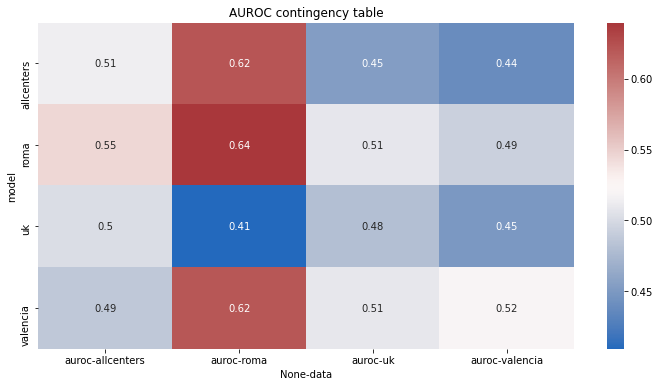

In [177]:
palette= sns.color_palette("vlag", as_cmap=True)
sns.heatmap(data = df_tralability_pivot, cmap = palette, annot = True)
plt.title('AUROC contingency table')
plt.show()
#plt.savefig(os.path.join(output_dir,'model_traslability.jpeg'))

#### ROC curves
##### ROC segmentals and euploids

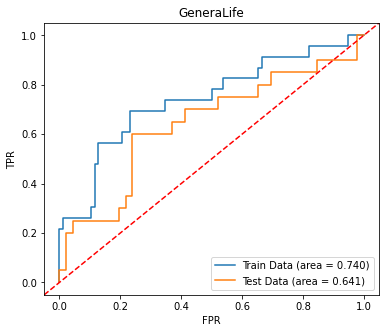

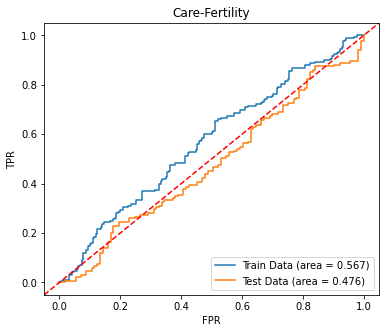

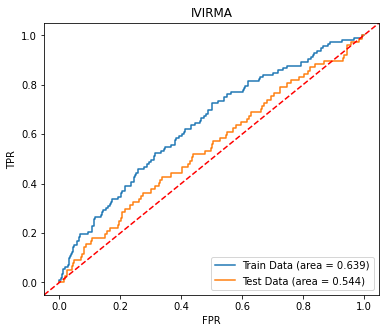

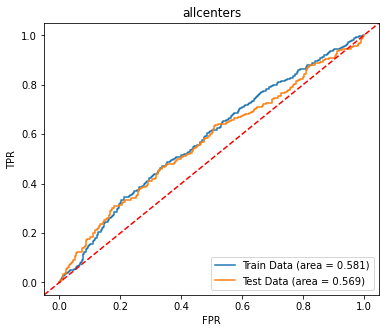

In [178]:
dataset_dict = {'GeneraLife':df_roma,'Care-Fertility':df_uk,'IVIRMA':df_valencia,'allcenters':df_all}


for center in dataset_dict.keys():
    dataset = dataset_dict[center]
    
    dataset_train0, dataset_test0 = train_test_split(dataset[dataset['class'].isin(['segm','eup'])], test_size=0.4,random_state=104)
    dataset_train = dataset_train0.copy()
    dataset_test = dataset_test0.copy()
    tl = TimeLapseAnalyzer()
    tl.train(dataset_train,
             model_feature_list = selected_feature_list+['pca_ll'],target='is_segmental')
    dataset_test_processed = tl.process_data(dataset_test,train=False)
    dataset_test_processed['segmental_score'] = tl.predict(dataset_test_processed)

    dataset_train_processed = tl.process_data(dataset_train,train=False)
    dataset_train_processed['segmental_score'] = tl.predict(dataset_train_processed)
    
    # eukutation on train set

    df_sel = dataset_train_processed[(dataset_train_processed.FLAG_QC==False)]
    y_test = df_sel['class']=='segm'
    y_pred_score = df_sel['segmental_score']
    logit_roc_auc_train = roc_auc_score(y_test,y_pred_score)
    fpr_train, tpr_train, thresholds = roc_curve(y_test, y_pred_score)

    df_sel = dataset_test_processed[(dataset_test_processed.FLAG_QC==False)]
    y_test = df_sel['class']=='segm'
    y_pred_score = df_sel['segmental_score']
    logit_roc_auc = roc_auc_score(y_test,y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)


    plt.figure(figsize=(6,5))
    plt.plot(fpr_train, tpr_train, label='Train Data (area = %0.3f)' % logit_roc_auc_train)
    plt.plot(fpr, tpr, label='Test Data (area = %0.3f)' % logit_roc_auc)

    #plt.plot(fpr_ida, tpr_ida, label='IDA Score (area = %0.3f)' % logit_roc_auc_ida)
    #plt.plot(fpr_grading, tpr_grading, label='Grading Score (area = %0.3f)' % logit_roc_auc_grading)

    plt.plot([-0.05, 1.05], [-0.05, 1.05],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(center)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig(os.path.join(output_dir,'roc_segm_vs_eup_'+center+'.jpeg'))

##### ROC euploids vs aneuploid

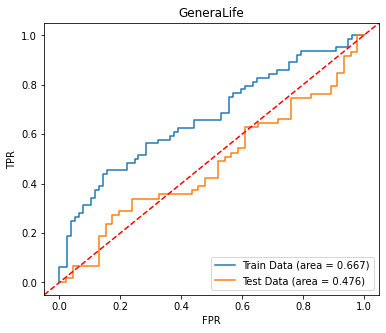

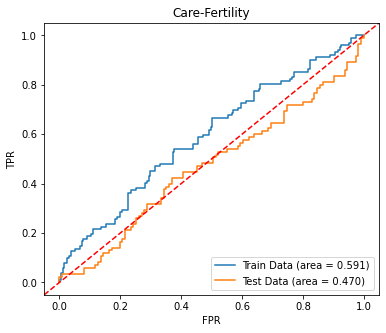

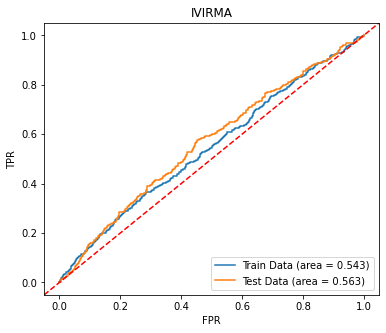

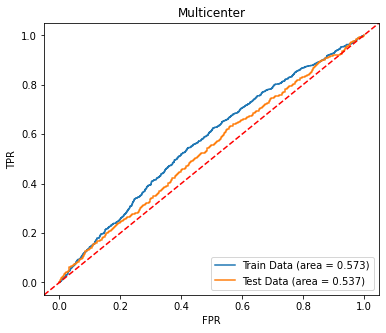

In [179]:
dataset_dict = {'GeneraLife':df_roma,'Care-Fertility':df_uk,'IVIRMA':df_valencia,'Multicenter':df_all}


for center in dataset_dict.keys():
    dataset = dataset_dict[center]
    
    dataset_train0, dataset_test0 = train_test_split(dataset[dataset['class'].isin(['aneup','eup'])], test_size=0.4,random_state=104)
    dataset_train = dataset_train0.copy()
    dataset_test = dataset_test0.copy()
    tl = TimeLapseAnalyzer()
    tl.train(dataset_train,
             model_feature_list = selected_feature_list+['pca_ll'],target='is_aneuploid')
    dataset_test_processed = tl.process_data(dataset_test,train=False)
    dataset_test_processed['aneup_score'] = tl.predict(dataset_test_processed)

    dataset_train_processed = tl.process_data(dataset_train,train=False)
    dataset_train_processed['aneup_score'] = tl.predict(dataset_train_processed)
    

    df_sel = dataset_train_processed[(dataset_train_processed.FLAG_QC==False)]
    y_test = df_sel['class']=='aneup'
    y_pred_score = df_sel['aneup_score']
    logit_roc_auc_train = roc_auc_score(y_test,y_pred_score)
    fpr_train, tpr_train, thresholds = roc_curve(y_test, y_pred_score)

    df_sel = dataset_test_processed[(dataset_test_processed.FLAG_QC==False)]
    y_test = df_sel['class']=='aneup'
    y_pred_score = df_sel['aneup_score']
    logit_roc_auc = roc_auc_score(y_test,y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)


    plt.figure(figsize=(6,5))
    plt.plot(fpr_train, tpr_train, label='Train Data (area = %0.3f)' % logit_roc_auc_train)
    plt.plot(fpr, tpr, label='Test Data (area = %0.3f)' % logit_roc_auc)
    plt.plot([-0.05, 1.05], [-0.05, 1.05],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(center)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig(os.path.join(output_dir,'roc_aneup_vs_eup_'+center+'.jpeg'))

##### ROC segmentals and euploids+aneuploids

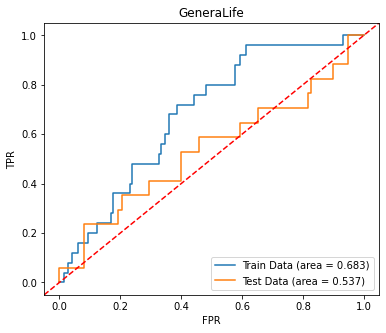

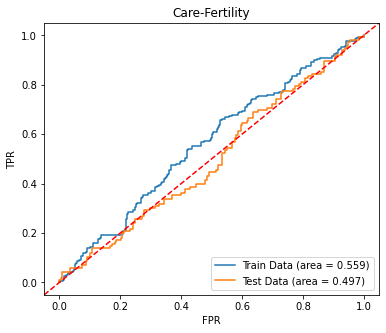

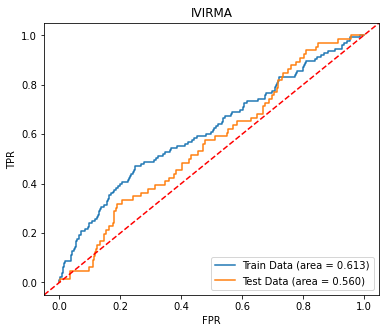

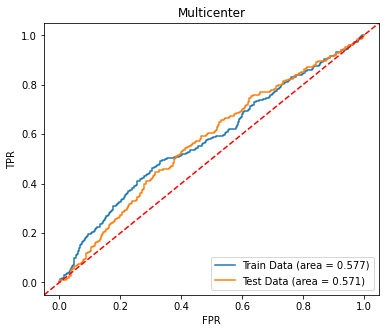

In [180]:
dataset_dict = {'GeneraLife':df_roma,'Care-Fertility':df_uk,'IVIRMA':df_valencia,'Multicenter':df_all}


for center in dataset_dict.keys():
    dataset = dataset_dict[center]
    
    dataset_train0, dataset_test0 = train_test_split(dataset[dataset['class'].isin(['segm','aneup','eup'])], test_size=0.4,random_state=104)
    dataset_train = dataset_train0.copy()
    dataset_test = dataset_test0.copy()
    tl = TimeLapseAnalyzer()
    tl.train(dataset_train,
             model_feature_list = selected_feature_list+['pca_ll'],target='is_segmental')
    dataset_test_processed = tl.process_data(dataset_test,train=False)
    dataset_test_processed['segmental_score'] = tl.predict(dataset_test_processed)

    dataset_train_processed = tl.process_data(dataset_train,train=False)
    dataset_train_processed['segmental_score'] = tl.predict(dataset_train_processed)
    
    # eukutation on train set

    df_sel = dataset_train_processed[(dataset_train_processed.FLAG_QC==False)]
    y_test = df_sel['class']=='segm'
    y_pred_score = df_sel['segmental_score']
    logit_roc_auc_train = roc_auc_score(y_test,y_pred_score)
    fpr_train, tpr_train, thresholds = roc_curve(y_test, y_pred_score)

    df_sel = dataset_test_processed[(dataset_test_processed.FLAG_QC==False)]
    y_test = df_sel['class']=='segm'
    y_pred_score = df_sel['segmental_score']
    logit_roc_auc = roc_auc_score(y_test,y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
    
    plt.figure(figsize=(6,5))
    plt.plot(fpr_train, tpr_train, label='Train Data (area = %0.3f)' % logit_roc_auc_train)
    plt.plot(fpr, tpr, label='Test Data (area = %0.3f)' % logit_roc_auc)
    plt.plot([-0.05, 1.05], [-0.05, 1.05],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(center)
    plt.legend(loc="lower right")

    #plt.savefig(os.path.join(output_dir,'roc_segm_vs_aneup_or_eup_'+center+'.jpeg'))

#### ROC for centers

<Figure size 864x432 with 0 Axes>

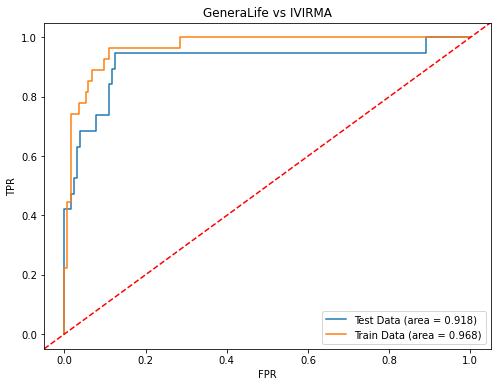

<Figure size 864x432 with 0 Axes>

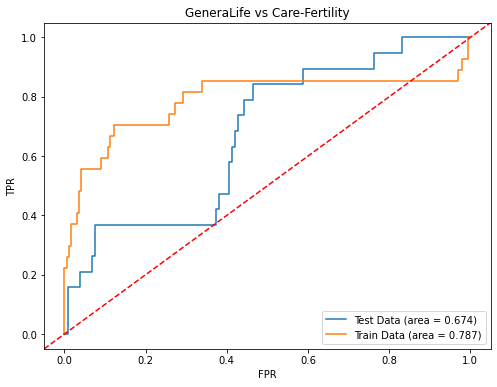

<Figure size 864x432 with 0 Axes>

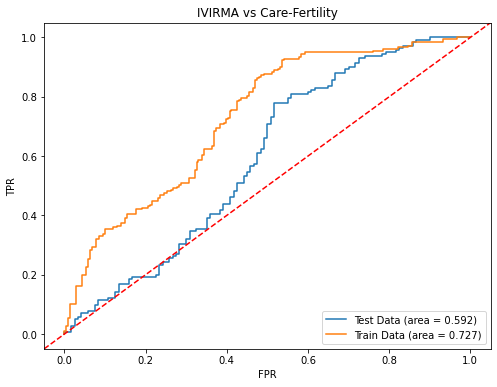

In [181]:
#1 split datasets
df_all['is_GeneraLife'] = df_all['centre_ID'] == 'GeneraLife'
df_all['is_IVIRMA'] = df_all['centre_ID'] == 'IVIRMA'
df_all['is_Care-Fertility'] = df_all['centre_ID'] == 'Care-Fertility'


for center1,center2 in [('GeneraLife','IVIRMA'),('GeneraLife','Care-Fertility'),('IVIRMA','Care-Fertility')]:
    target = 'is_'+ center1

    df_center_train0, df_center_test0 = train_test_split(df_all[(df_all['class']=='segm')
                                                                &(df_all['centre_ID'].isin([center1,center2]))], 
                                                         test_size=0.4,random_state=104)
    df_center_train = df_center_train0.copy()
    df_center_test = df_center_test0.copy()


    #1 train 4 models: model specific and global model
    tl_center = TimeLapseAnalyzer()
    tl_center.train(df_center_train,model_feature_list = tl_center.imputed_times+['pca_ll'],target=target)
    df_center_train_processed = tl_center.process_data(df_center_train,train=False)
    df_center_test_processed = tl_center.process_data(df_center_test,train=False)
    df_center_train_processed['center_score'] = tl_center.predict(df_center_train_processed)
    df_center_test_processed['center_score'] = tl_center.predict(df_center_test_processed)
    
    # evalutation on test set
    plt.figure()
    y_pred_score = df_center_test_processed['center_score']
    y_test = df_center_test_processed[target]
    logit_roc_auc = roc_auc_score(y_test,y_pred_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)

    y_pred_score = df_center_train_processed['center_score']
    y_test = df_center_train_processed[target]
    logit_roc_auc_train = roc_auc_score(y_test,y_pred_score)
    fpr_train, tpr_train, thresholds = roc_curve(y_test, y_pred_score)

    plt.figure(figsize=(8,6))
    plt.title(center1+' vs '+center2)
    plt.plot(fpr, tpr, label='Test Data (area = %0.3f)' % logit_roc_auc)
    plt.plot(fpr_train, tpr_train, label='Train Data (area = %0.3f)' % logit_roc_auc_train)


    plt.plot([-0.05, 1.05], [-0.05, 1.05],'r--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    #plt.title('Curve ROC per centro')
    plt.legend(loc="lower right")
    #plt.savefig(os.path.join(output_dir,'roc_'+center1+'_vs_'+center2+'.jpeg'))

#### Filtering quality

In [87]:
df_processed_all = tl_all.process_data(df_all, train=False)
predictions = tl_all.predict(df_processed_all)

In [88]:
display(df_processed_all[['FLAG_QC','FLAG_QC_NUM_MISSING',
    'FLAG_QC_NOT_MONOTONY','FLAG_QC_MISSING_BLASTO','FLAG_QC_PCA']].mean())

display(df_processed_all.groupby('centre_ID')[['FLAG_QC','FLAG_QC_NUM_MISSING',
 'FLAG_QC_MISSING_BLASTO', 'FLAG_QC_NOT_MONOTONY','FLAG_QC_PCA']].mean())

display(df_processed_all.groupby('class')[['FLAG_QC','FLAG_QC_NUM_MISSING',
 'FLAG_QC_MISSING_BLASTO', 'FLAG_QC_NOT_MONOTONY','FLAG_QC_PCA']].mean())

FLAG_QC                   0.274407
FLAG_QC_NUM_MISSING       0.206657
FLAG_QC_NOT_MONOTONY      0.004849
FLAG_QC_MISSING_BLASTO    0.102739
FLAG_QC_PCA               0.012973
dtype: float64

,FLAG_QC,FLAG_QC_NUM_MISSING,FLAG_QC_MISSING_BLASTO,FLAG_QC_NOT_MONOTONY,FLAG_QC_PCA
centre_ID,,,,,
Care-Fertility,0.053555,0.008310,0.045245,0.001847,0.005540
GeneraLife,0.165829,0.032663,0.105528,0.020101,0.060302
IVIRMA,0.336459,0.278759,0.111432,0.002164,0.010819
bologna,0.000000,0.000000,0.000000,0.000000,0.000000
roma_unblind,0.189435,0.016393,0.136612,0.027322,0.016393


,FLAG_QC,FLAG_QC_NUM_MISSING,FLAG_QC_MISSING_BLASTO,FLAG_QC_NOT_MONOTONY,FLAG_QC_PCA
class,,,,,
aneup,0.300191,0.221410,0.118170,0.005400,0.015248
eup,0.266829,0.210478,0.088943,0.004264,0.011270
segm,0.216901,0.156338,0.092958,0.002817,0.011268
segm+aneup,0.242857,0.159184,0.110204,0.008163,0.012245


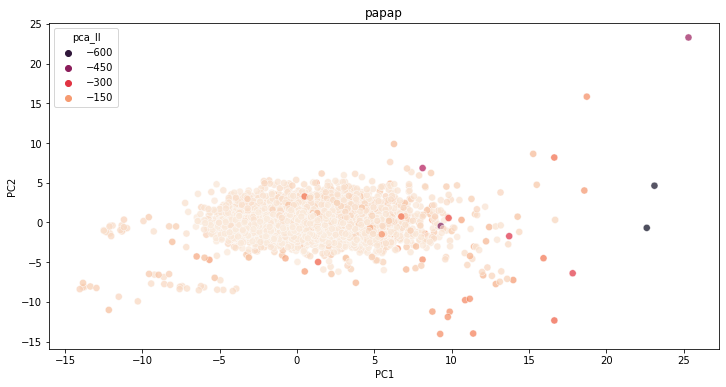

In [89]:
palette = sns.color_palette("rocket", as_cmap=True)
sns.scatterplot(data=df_processed_all, x='pca1', y='pca2', hue='pca_ll',s=50,palette=palette,alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('papap')
plt.show()
#plt.savefig(os.path.join(output_dir,'pca_outlers_all_ll.jpeg'))


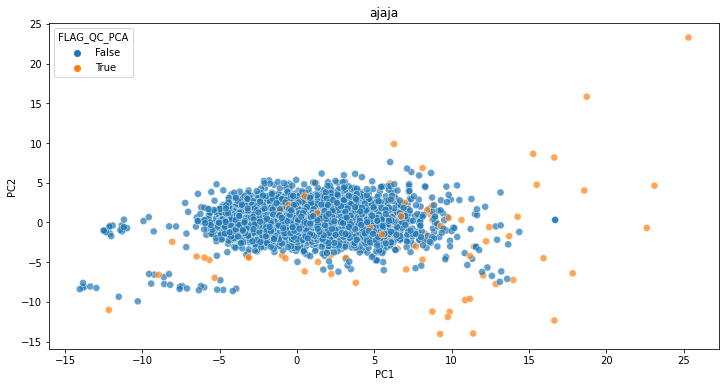

In [90]:
sns.scatterplot(data=df_processed_all,x='pca1',y='pca2',hue='FLAG_QC_PCA',s=50,alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ajaja')
plt.show()
#plt.savefig(os.path.join(output_dir,'pca_outlers_all_QC.jpeg'))

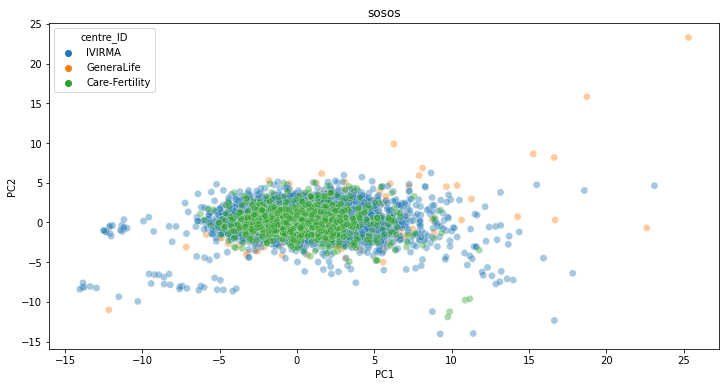

In [91]:
sns.scatterplot(data=df_processed_all[df_processed_all.centre_ID.isin(['IVIRMA','GeneraLife','Care-Fertility'])],x='pca1',y='pca2',hue='centre_ID',s=50,alpha=0.4,hue_order=['IVIRMA','GeneraLife','Care-Fertility'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('sosos')
plt.show()
#plt.savefig(os.path.join(output_dir,'pca_outlers_all_centers.jpeg'))

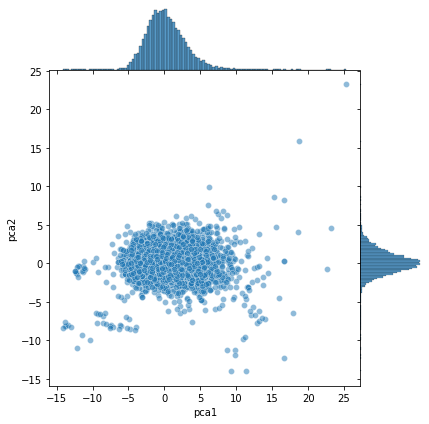

In [92]:
palette = sns.color_palette("rocket", as_cmap=True)
ax = sns.jointplot(x=df_processed_all['pca1'],y=df_processed_all['pca2'],
                   kind='scatter',
                   space=0,
                   alpha=0.5)

#### Outliers trajectories

In [93]:
list_outliers = df_processed_all.sort_values('pca_ll').index[0:8].values

In [94]:
list_outliers

array([ 266, 2928, 4838,   14,    0, 3882,  435, 5600])

In [95]:
df_processed_all.columns

Index(['centre_ID', 'patient_ID', 'treatment_ID', 'embryo_ID', 'classification', 'tPB2', 'tPNa',
       'tPNf', 't2', 't3',
       ...
       'blast_imp_z', 'blast1_imp_z', 'pca_ll', 'pca1', 'pca2', 'FLAG_QC_PCA', 'FLAG_QC',
       'QC_REASON', 'ritardo_max', 'ritardo_min'],
      dtype='object', length=161)

#### Delays trajectories
1. Full dataset
2. IVIRMA
3. Care-Fertility
4. GeneraLife

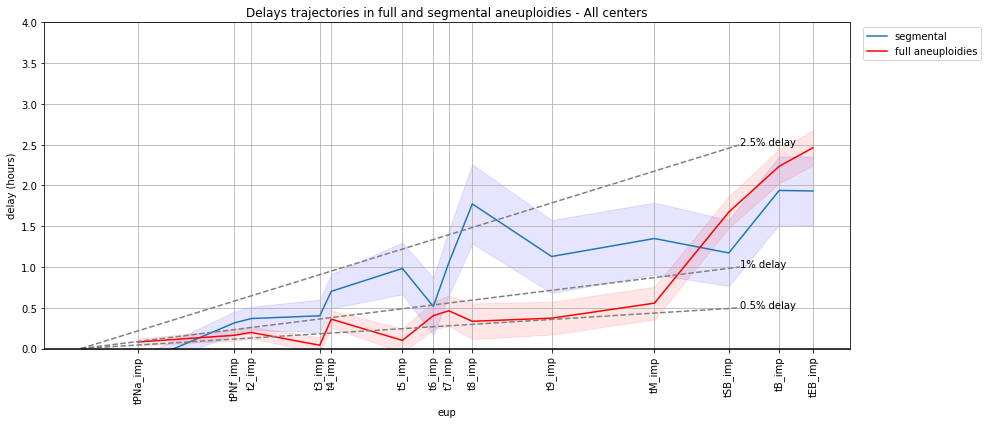

In [96]:
#trajectories full dataset
dataset = df_all_processed[df_all_processed.FLAG_QC==False]
plotting_times = ['tPNa_imp', 'tPNf_imp', 't2_imp', 't3_imp', 't4_imp',
       't5_imp', 't6_imp', 't7_imp', 't8_imp', 't9_imp', 'tM_imp',
       'tSB_imp', 'tB_imp', 'tEB_imp']
plt.title('Delays trajectories in full and segmental aneuploidies - All centers')
plot_trajectory_new(dataset,plotting_times,outfile=os.path.join(output_dir,'trajectories_all.jpeg'))
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylim(0, 4)
plt.show()

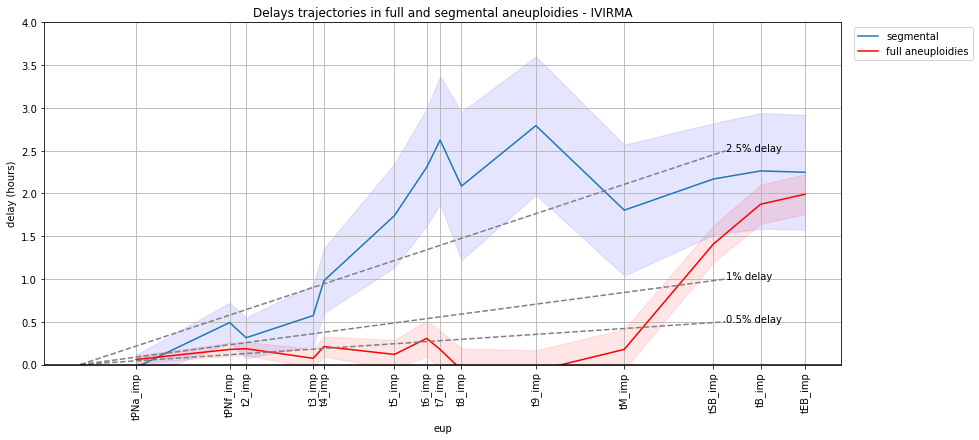

In [97]:
#trajectories val
dataset = df_valencia_processed[df_valencia_processed.FLAG_QC==False]
plotting_times = ['tPNa_imp', 'tPNf_imp', 't2_imp', 't3_imp', 't4_imp',
       't5_imp', 't6_imp', 't7_imp', 't8_imp', 't9_imp', 'tM_imp',
       'tSB_imp', 'tB_imp', 'tEB_imp']
plot_trajectory_new(dataset,plotting_times,outfile=os.path.join(output_dir,'trajectories_valencia.jpeg'))
plt.title('Delays trajectories in full and segmental aneuploidies - IVIRMA')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylim(0, 4)
plt.show()

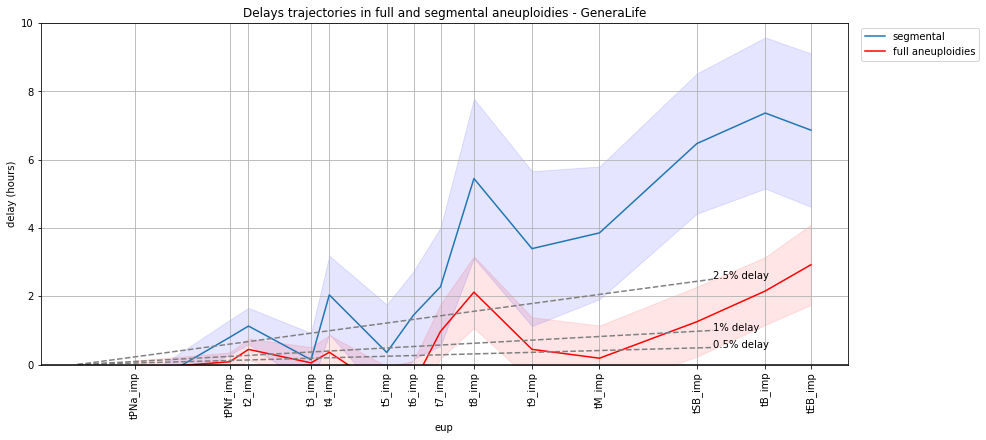

In [98]:
dataset = df_roma_processed[df_roma_processed.FLAG_QC==False]
plotting_times = ['tPNa_imp', 'tPNf_imp', 't2_imp', 't3_imp', 't4_imp',
       't5_imp', 't6_imp', 't7_imp', 't8_imp', 't9_imp', 'tM_imp',
       'tSB_imp', 'tB_imp', 'tEB_imp']
plot_trajectory_new(dataset,plotting_times,outfile=os.path.join(output_dir,'trajectories_roma.jpeg'))
plt.title('Delays trajectories in full and segmental aneuploidies - GeneraLife')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylim(0, 10)
plt.show()

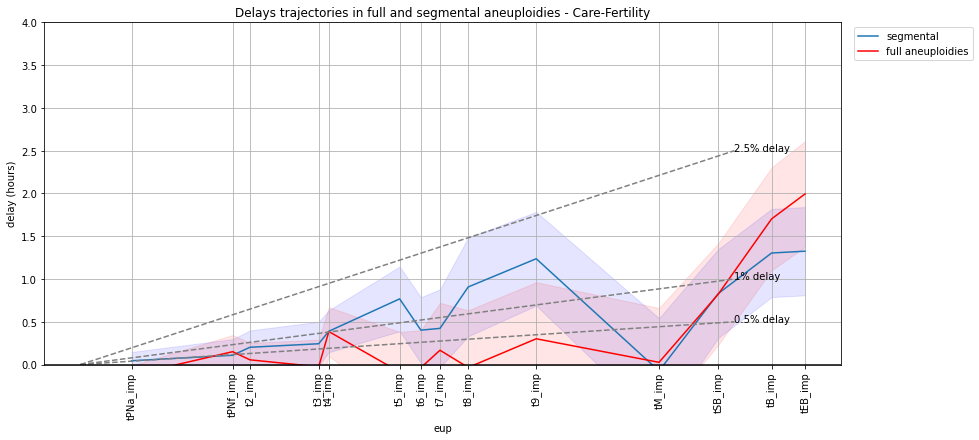

In [99]:
#trajectories uk
dataset = df_uk_processed[df_uk_processed.FLAG_QC==False]
plotting_times = ['tPNa_imp', 'tPNf_imp', 't2_imp', 't3_imp', 't4_imp',
       't5_imp', 't6_imp', 't7_imp', 't8_imp', 't9_imp', 'tM_imp',
       'tSB_imp', 'tB_imp', 'tEB_imp']
plot_trajectory_new(dataset,plotting_times,outfile=os.path.join(output_dir,'trajectories_uk.jpeg'))
plt.title('Delays trajectories in full and segmental aneuploidies - Care-Fertility')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylim(0, 4)
plt.show()